# Gesture Identification Model Training
## By Luke Corcoran
### G00410404

In [125]:
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import time
import shutil
import glob
from pathlib import Path
import tensorflow_hub as hub
from PIL import Image
import pandas as pd
from tensorflow.keras.applications.vgg16 import preprocess_input
import timeit
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Tensorflow Version

In [2]:
tf.__version__

'2.18.0'

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extraction and Processing of Data

In [4]:
seed_value = 410404
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [5]:
zip_path = '/content/drive/MyDrive/rock-paper-scissors.zip'
extract_dir = '/content/rock-paper-scissors'


In [6]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Dataset extracted to /content/rock-paper-scissors


In [7]:
image_size = 80
input_shape = (image_size, image_size, 3)
batch_size = 32

In [8]:
dataset_path = os.path.join(extract_dir, 'rock-paper-scissors/Rock-Paper-Scissors')

combined_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    image_size=(image_size, image_size),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

val_ds_original = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'validation'),
    image_size=(image_size, image_size),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

test_ds_original = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    image_size=(image_size, image_size),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

combined_ds = combined_ds.concatenate(val_ds_original).concatenate(test_ds_original)

total_size = len(list(combined_ds))
print(f"Total dataset size: {total_size} images")

Found 2520 files belonging to 3 classes.
Found 33 files belonging to 3 classes.
Found 372 files belonging to 3 classes.
Total dataset size: 2925 images


In [9]:
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Training set: {train_size} images (70%)")
print(f"Validation set: {val_size} images (10%)")
print(f"Test set: {test_size} images (20%)")

Training set: 2047 images (70%)
Validation set: 292 images (10%)
Test set: 586 images (20%)


In [10]:
class_names = ['paper', 'rock', 'scissors']

train_ds = combined_ds.take(train_size).batch(batch_size)
temp_ds = combined_ds.skip(train_size)
val_ds = temp_ds.take(val_size).batch(batch_size)
test_ds = temp_ds.skip(val_size).batch(batch_size)

num_classes = len(class_names)

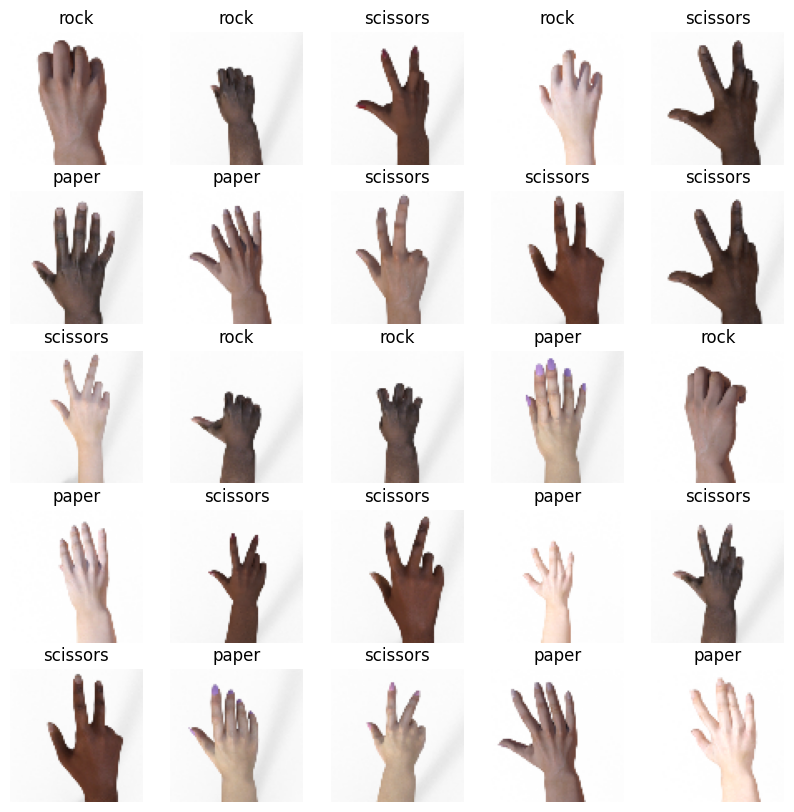

In [11]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(combined_ds.take(25)):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.numpy().astype("uint8"), cmap='gray')

    label_index = label.numpy()[0] if tf.rank(label) > 0 else label.numpy()
    plt.title(class_names[label_index])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# Training of CNNs from Scratch
## Standard CNN

In [13]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,644,003 (6.27 MB)

 Trainable params: 1,644,003 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
checkpoint_filepath = '/content/drive/MyDrive/cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [15]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
    ),
    model_checkpoint_callback
]


In [16]:
start_timer = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback
)

end_timer = time.time()
training_time = end_timer - start_timer

print(f"Normal RGB model - Training took {training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3774 - loss: 1.0980
Epoch 1: val_loss improved from inf to 1.04250, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.3785 - loss: 1.0977 - val_accuracy: 0.4589 - val_loss: 1.0425
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4990 - loss: 1.0439
Epoch 2: val_loss improved from 1.04250 to 0.99023, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4999 - loss: 1.0436 - val_accuracy: 0.6849 - val_loss: 0.9902
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6265 - loss: 0.9781
Epoch 3: val_loss improved from 0.99023 to 0.93048, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6272 - loss: 0.9774 - val_accuracy: 0.6815 - val_loss: 0.9305
Epoch 4/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6883 - loss: 0.9273 
Epoch 4: val_loss improved from 0.93048 to 0.89229, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6872 - loss: 0.9264 - val_accuracy: 0.6370 - val_loss: 0.8923
Epoch 5/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7250 - loss: 0.8625
Epoch 5: val_loss improved from 0.89229 to 0.81275, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7270 - loss: 0.8617 - val_accuracy: 0.8253 - val_loss: 0.8127
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7983 - loss: 0.7978
Epoch 6: val_loss improved from 0.81275 to 0.74670, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7983 - loss: 0.7970 - val_accuracy: 0.8014 - val_loss: 0.7467
Epoch 7/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8272 - loss: 0.7353
Epoch 7: val_loss improved from 0.74670 to 0.68897, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8269 - loss: 0.7349 - val_accuracy: 0.8219 - val_loss: 0.6890
Epoch 8/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8315 - loss: 0.6812
Epoch 8: val_loss improved from 0.68897 to 0.66310, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8309 - loss: 0.6805 - val_accuracy: 0.8699 - val_loss: 0.6631
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8616 - loss: 0.6036
Epoch 9: val_loss improved from 0.66310 to 0.56433, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8615 - loss: 0.6035 - val_accuracy: 0.8904 - val_loss: 0.5643
Epoch 10/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8720 - loss: 0.5641
Epoch 10: val_loss did not improve from 0.56433
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8725 - loss: 0.5633 - val_accuracy: 0.8664 - val_loss: 0.5846
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9132 - loss: 0.5124
Epoch 11: val_loss improved from 0.56433 to 0.45535, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9132 - loss: 0.5122 - val_accuracy: 0.9281 - val_loss: 0.4554
Epoch 12/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9168 - loss: 0.4631
Epoch 12: val_loss improved from 0.45535 to 0.42082, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9174 - loss: 0.4626 - val_accuracy: 0.9623 - val_loss: 0.4208
Epoch 13/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9514 - loss: 0.4182
Epoch 13: val_loss did not improve from 0.42082
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9512 - loss: 0.4182 - val_accuracy: 0.9349 - val_loss: 0.4320
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9515 - loss: 0.3840
Epoch 14: val_loss improved from 0.42082 to 0.38008, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9515 - loss: 0.3839 - val_accuracy: 0.9486 - val_loss: 0.3801
Epoch 15/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9605 - loss: 0.3504
Epoch 15: val_loss improved from 0.38008 to 0.33164, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9607 - loss: 0.3495 - val_accuracy: 0.9623 - val_loss: 0.3316
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9643 - loss: 0.3033
Epoch 16: val_loss improved from 0.33164 to 0.30578, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9643 - loss: 0.3033 - val_accuracy: 0.9589 - val_loss: 0.3058
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9736 - loss: 0.2793
Epoch 17: val_loss improved from 0.30578 to 0.27136, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9736 - loss: 0.2793 - val_accuracy: 0.9795 - val_loss: 0.2714
Epoch 18/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9709 - loss: 0.2623
Epoch 18: val_loss improved from 0.27136 to 0.23043, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9710 - loss: 0.2622 - val_accuracy: 0.9795 - val_loss: 0.2304
Epoch 19/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9786 - loss: 0.2339
Epoch 19: val_loss improved from 0.23043 to 0.19680, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9786 - loss: 0.2339 - val_accuracy: 0.9966 - val_loss: 0.1968
Epoch 20/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9811 - loss: 0.2215
Epoch 20: val_loss did not improve from 0.19680
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9811 - loss: 0.2213 - val_accuracy: 0.9863 - val_loss: 0.2135
Epoch 21/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9846 - loss: 0.2094
Epoch 21: val_loss improved from 0.19680 to 0.18090, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9846 - loss: 0.2090 - val_accuracy: 0.9932 - val_loss: 0.1809
Epoch 22/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9873 - loss: 0.1945
Epoch 22: val_loss improved from 0.18090 to 0.17059, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9873 - loss: 0.1941 - val_accuracy: 0.9897 - val_loss: 0.1706
Epoch 23/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9909 - loss: 0.1733
Epoch 23: val_loss improved from 0.17059 to 0.15366, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9907 - loss: 0.1731 - val_accuracy: 0.9966 - val_loss: 0.1537
Epoch 24/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9876 - loss: 0.1650
Epoch 24: val_loss improved from 0.15366 to 0.14186, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9876 - loss: 0.1649 - val_accuracy: 0.9966 - val_loss: 0.1419
Epoch 25/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9921 - loss: 0.1490
Epoch 25: val_loss did not improve from 0.14186
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9920 - loss: 0.1490 - val_accuracy: 1.0000 - val_loss: 0.1448
Epoch 26/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9906 - loss: 0.1428
Epoch 26: val_loss improved from 0.14186 to 0.12680, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9905 - loss: 0.1427 - val_accuracy: 0.9863 - val_loss: 0.1268
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9898 - loss: 0.1342
Epoch 27: val_loss improved from 0.12680 to 0.11927, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9898 - loss: 0.1342 - val_accuracy: 0.9932 - val_loss: 0.1193
Epoch 28/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9902 - loss: 0.1216
Epoch 28: val_loss improved from 0.11927 to 0.11739, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9901 - loss: 0.1218 - val_accuracy: 0.9897 - val_loss: 0.1174
Epoch 29/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9930 - loss: 0.1149
Epoch 29: val_loss improved from 0.11739 to 0.11096, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9930 - loss: 0.1148 - val_accuracy: 0.9932 - val_loss: 0.1110
Epoch 30/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9908 - loss: 0.1136
Epoch 30: val_loss improved from 0.11096 to 0.09320, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9908 - loss: 0.1134 - val_accuracy: 1.0000 - val_loss: 0.0932
Epoch 31/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9886 - loss: 0.1017
Epoch 31: val_loss did not improve from 0.09320
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9887 - loss: 0.1018 - val_accuracy: 0.9932 - val_loss: 0.1039
Epoch 32/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9920 - loss: 0.1019
Epoch 32: val_loss improved from 0.09320 to 0.08982, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9921 - loss: 0.1017 - val_accuracy: 0.9966 - val_loss: 0.0898
Epoch 33/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9914 - loss: 0.0900
Epoch 33: val_loss improved from 0.08982 to 0.08873, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9914 - loss: 0.0900 - val_accuracy: 0.9897 - val_loss: 0.0887
Epoch 34/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9918 - loss: 0.0883
Epoch 34: val_loss did not improve from 0.08873
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9919 - loss: 0.0880 - val_accuracy: 0.9897 - val_loss: 0.0934
Epoch 35/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9926 - loss: 0.0842
Epoch 35: val_loss improved from 0.08873 to 0.07189, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9927 - loss: 0.0839 - val_accuracy: 0.9966 - val_loss: 0.0719
Epoch 36/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0731 
Epoch 36: val_loss did not improve from 0.07189
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9953 - loss: 0.0732 - val_accuracy: 0.9966 - val_loss: 0.0775
Epoch 37/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9970 - loss: 0.0747
Epoch 37: val_loss improved from 0.07189 to 0.06536, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9970 - loss: 0.0746 - val_accuracy: 0.9966 - val_loss: 0.0654
Epoch 38/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9963 - loss: 0.0695
Epoch 38: val_loss did not improve from 0.06536
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9962 - loss: 0.0694 - val_accuracy: 1.0000 - val_loss: 0.0682
Epoch 39/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9962 - loss: 0.0640
Epoch 39: val_loss improved from 0.06536 to 0.05744, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9962 - loss: 0.0641 - val_accuracy: 0.9966 - val_loss: 0.0574
Epoch 40/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0625
Epoch 40: val_loss did not improve from 0.05744
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9965 - loss: 0.0625 - val_accuracy: 0.9932 - val_loss: 0.0673
Epoch 41/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9943 - loss: 0.0618
Epoch 41: val_loss improved from 0.05744 to 0.04902, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9943 - loss: 0.0617 - val_accuracy: 1.0000 - val_loss: 0.0490
Epoch 42/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0535
Epoch 42: val_loss did not improve from 0.04902
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9968 - loss: 0.0535 - val_accuracy: 0.9932 - val_loss: 0.0523
Epoch 43/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9957 - loss: 0.0522
Epoch 43: val_loss improved from 0.04902 to 0.04522, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9957 - loss: 0.0523 - val_accuracy: 0.9966 - val_loss: 0.0452
Epoch 44/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9980 - loss: 0.0527
Epoch 44: val_loss did not improve from 0.04522
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9979 - loss: 0.0527 - val_accuracy: 1.0000 - val_loss: 0.0471
Epoch 45/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0483
Epoch 45: val_loss did not improve from 0.04522
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9979 - loss: 0.0484 - val_accuracy: 0.9966 - val_loss: 0.0513
Epoch 46/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9956 - loss: 0.0473
Epoch 46: val_loss improved from 0.04522 to 0.04055, saving model to /content/drive/MyDrive/cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9957 - loss: 0.0471 - val_accuracy: 1.0000 - val_loss: 0.0406
Epoch 47/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.0464
Epoch 47: val_loss did not improve from 0.04055
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9960 - loss: 0.0463 - val_accuracy: 0.9932 - val_loss: 0.0432
Epoch 48/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0407
Epoch 48: val_loss did not improve from 0.04055
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9972 - loss: 0.0409 - val_accuracy: 0.9897 - val_loss: 0.0525
Epoch 49/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9953 - loss: 0.0443
Epoch 49: val_loss did not improve from 0.04055
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9954 - loss: 0.0440 - val_accuracy: 0.9863 - val_loss: 0.0570
Normal RGB model - Training took 74.57 seconds


In [17]:
best_epoch_index = np.argmin(history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = history.history['val_loss'][best_epoch_index]
best_val_accuracy = history.history['val_accuracy'][best_epoch_index]
best_training_loss = history.history['loss'][best_epoch_index]
best_training_accuracy = history.history['accuracy'][best_epoch_index]

print("CNN Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {training_time:.2f} seconds")

CNN Model Information:
Best Epoch: 46
Validation Loss: 0.040553
Validation Accuracy: 1.000000
Training Loss: 0.044521
Training Accuracy: 0.997069
Training Time: 74.57 seconds


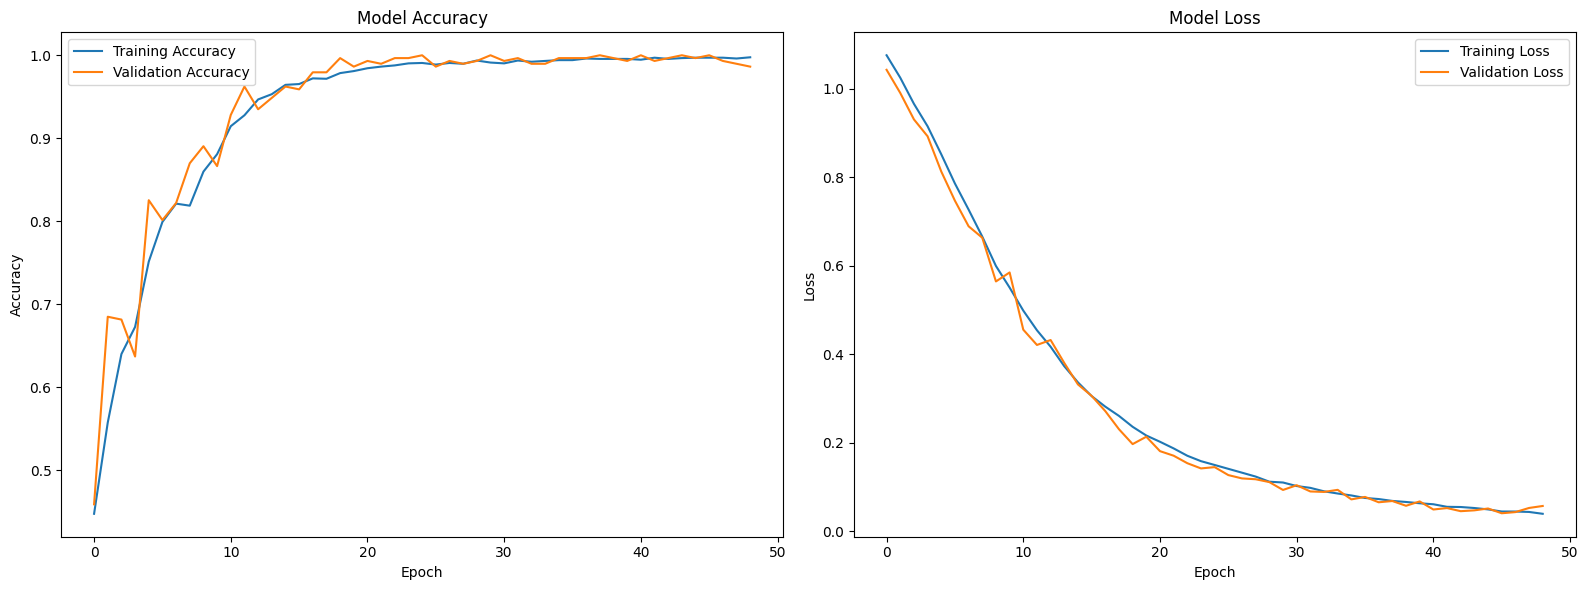

In [18]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Deeper CNN

In [19]:
deeper_model = tf.keras.models.Sequential()

deeper_model.add(tf.keras.Input(shape=input_shape))
deeper_model.add(layers.Rescaling(1./255))

deeper_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
deeper_model.add(layers.MaxPooling2D())

deeper_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
deeper_model.add(layers.MaxPooling2D())

deeper_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
deeper_model.add(layers.MaxPooling2D())

deeper_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
deeper_model.add(layers.MaxPooling2D())

deeper_model.add(layers.Flatten())

deeper_model.add(layers.Dense(512, activation='relu'))
deeper_model.add(layers.Dense(256, activation='relu'))
deeper_model.add(layers.Dense(128, activation='relu'))
deeper_model.add(layers.Dense(num_classes))

deeper_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,830,339 (14.61 MB)

 Trainable params: 3,830,339 (14.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_filepath = '/content/drive/MyDrive/deeper_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [21]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

deeper_start_time = time.time()
deeper_history = deeper_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback
)
deeper_end_time = time.time()
deeper_training_time = deeper_end_time - deeper_start_time
print(f"Deeper RGB model - Training took {deeper_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4180 - loss: 1.0909
Epoch 1: val_loss improved from inf to 1.06481, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.4192 - loss: 1.0908 - val_accuracy: 0.6267 - val_loss: 1.0648
Epoch 2/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6352 - loss: 1.0593
Epoch 2: val_loss improved from 1.06481 to 1.00661, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6369 - loss: 1.0585 - val_accuracy: 0.7500 - val_loss: 1.0066
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7595 - loss: 0.9875
Epoch 3: val_loss improved from 1.00661 to 0.88088, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7598 - loss: 0.9854 - val_accuracy: 0.8048 - val_loss: 0.8809
Epoch 4/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7717 - loss: 0.8445
Epoch 4: val_loss improved from 0.88088 to 0.71025, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7724 - loss: 0.8426 - val_accuracy: 0.7911 - val_loss: 0.7102
Epoch 5/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8443 - loss: 0.6566
Epoch 5: val_loss improved from 0.71025 to 0.54313, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8455 - loss: 0.6543 - val_accuracy: 0.8664 - val_loss: 0.5431
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9028 - loss: 0.4743 
Epoch 6: val_loss improved from 0.54313 to 0.35223, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9028 - loss: 0.4727 - val_accuracy: 0.9589 - val_loss: 0.3522
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9314 - loss: 0.3500
Epoch 7: val_loss improved from 0.35223 to 0.27017, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9316 - loss: 0.3497 - val_accuracy: 0.9589 - val_loss: 0.2702
Epoch 8/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9580 - loss: 0.2606
Epoch 8: val_loss improved from 0.27017 to 0.19367, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9582 - loss: 0.2599 - val_accuracy: 0.9658 - val_loss: 0.1937
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9631 - loss: 0.2074
Epoch 9: val_loss improved from 0.19367 to 0.14525, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9635 - loss: 0.2066 - val_accuracy: 0.9829 - val_loss: 0.1452
Epoch 10/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9758 - loss: 0.1663
Epoch 10: val_loss improved from 0.14525 to 0.14011, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9759 - loss: 0.1657 - val_accuracy: 0.9863 - val_loss: 0.1401
Epoch 11/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9808 - loss: 0.1289
Epoch 11: val_loss did not improve from 0.14011
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9809 - loss: 0.1288 - val_accuracy: 0.9589 - val_loss: 0.1513
Epoch 12/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.1069
Epoch 12: val_loss improved from 0.14011 to 0.12422, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9842 - loss: 0.1068 - val_accuracy: 0.9692 - val_loss: 0.1242
Epoch 13/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9905 - loss: 0.0827
Epoch 13: val_loss improved from 0.12422 to 0.09172, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9904 - loss: 0.0829 - val_accuracy: 0.9795 - val_loss: 0.0917
Epoch 14/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9897 - loss: 0.0750
Epoch 14: val_loss did not improve from 0.09172
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9897 - loss: 0.0749 - val_accuracy: 0.9897 - val_loss: 0.0960
Epoch 15/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9881 - loss: 0.0775
Epoch 15: val_loss improved from 0.09172 to 0.05126, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9881 - loss: 0.0772 - val_accuracy: 0.9932 - val_loss: 0.0513
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9896 - loss: 0.0581
Epoch 16: val_loss improved from 0.05126 to 0.04035, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9896 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.0404
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9907 - loss: 0.0540
Epoch 17: val_loss did not improve from 0.04035
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9907 - loss: 0.0539 - val_accuracy: 0.9966 - val_loss: 0.0469
Epoch 18/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.0421
Epoch 18: val_loss did not improve from 0.04035
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9964 - loss: 0.0421 - val_accuracy: 0.9829 - val_loss: 0.0600
Epoch 19/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9921 - loss: 0.0436
Epoch 19: val_loss improved from 0.04035 to 0.02390, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9922 - loss: 0.0434 - val_accuracy: 0.9966 - val_loss: 0.0239
Epoch 20/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9945 - loss: 0.0349
Epoch 20: val_loss did not improve from 0.02390
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9945 - loss: 0.0350 - val_accuracy: 0.9863 - val_loss: 0.0515
Epoch 21/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9955 - loss: 0.0327
Epoch 21: val_loss did not improve from 0.02390
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9955 - loss: 0.0327 - val_accuracy: 0.9897 - val_loss: 0.0450
Epoch 22/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0292
Epoch 22: val_loss improved from 0.02390 to 0.02382, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9960 - loss: 0.0292 - val_accuracy: 0.9966 - val_loss: 0.0238
Epoch 23/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9984 - loss: 0.0216
Epoch 23: val_loss improved from 0.02382 to 0.01914, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9983 - loss: 0.0218 - val_accuracy: 0.9966 - val_loss: 0.0191
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.0220
Epoch 24: val_loss improved from 0.01914 to 0.01415, saving model to /content/drive/MyDrive/deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9978 - loss: 0.0222 - val_accuracy: 0.9966 - val_loss: 0.0142
Epoch 25/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9969 - loss: 0.0217
Epoch 25: val_loss did not improve from 0.01415
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9969 - loss: 0.0217 - val_accuracy: 0.9966 - val_loss: 0.0226
Epoch 26/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9978 - loss: 0.0155
Epoch 26: val_loss did not improve from 0.01415
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9978 - loss: 0.0156 - val_accuracy: 1.0000 - val_loss: 0.0174
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9954 - loss: 0.0200
Epoch 27: val_loss did not improve from 0.01415
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9954 - loss: 0.0200 - val_accuracy: 0.9966 - val_loss: 0.0182
Deeper RGB model - Training took 59.25 seconds


In [22]:
best_epoch_index = np.argmin(deeper_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = deeper_history.history['val_loss'][best_epoch_index]
best_val_accuracy = deeper_history.history['val_accuracy'][best_epoch_index]
best_training_loss = deeper_history.history['loss'][best_epoch_index]
best_training_accuracy = deeper_history.history['accuracy'][best_epoch_index]

print("Deeper Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {deeper_training_time:.2f} seconds")

Deeper Model Information:
Best Epoch: 24
Validation Loss: 0.014150
Validation Accuracy: 0.996575
Training Loss: 0.024039
Training Accuracy: 0.997069
Training Time: 59.25 seconds


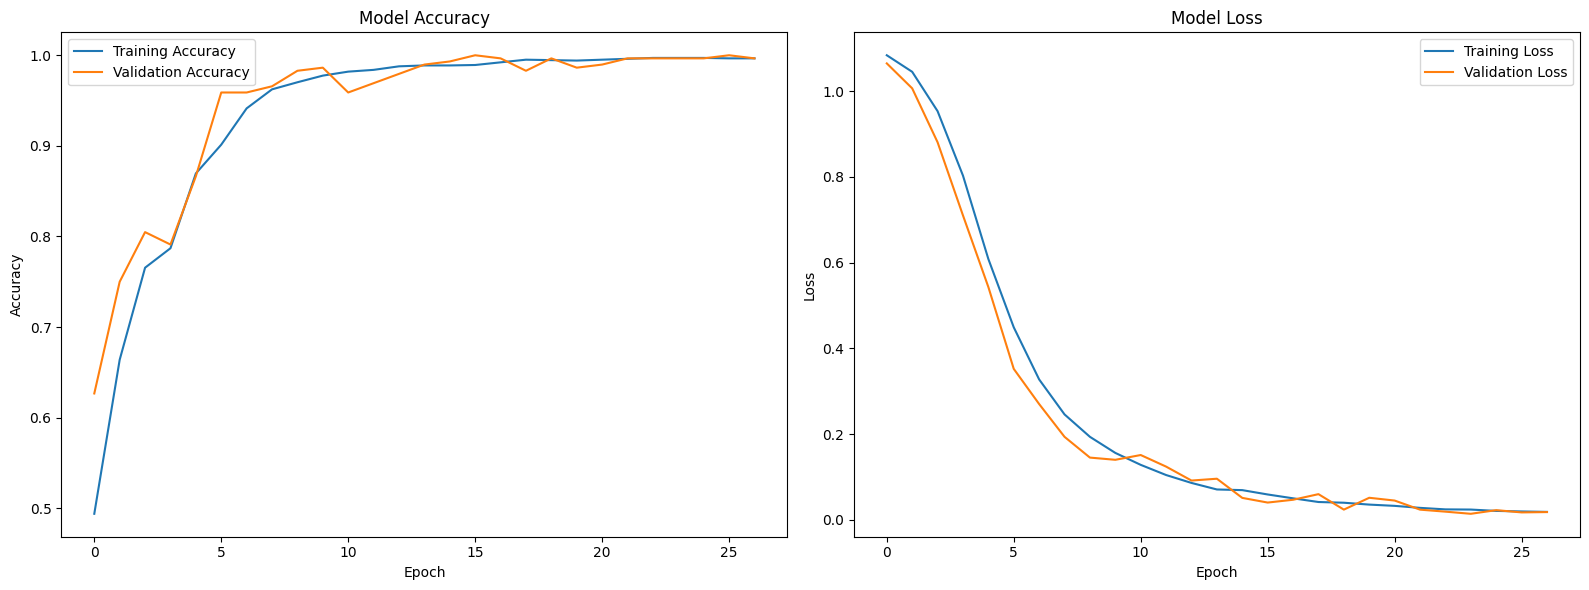

In [23]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(deeper_history.history['accuracy'], label='Training Accuracy')
plt.plot(deeper_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deeper_history.history['loss'], label='Training Loss')
plt.plot(deeper_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## CNN with Data Augmentation

In [24]:
data_augmentation_layers = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [25]:
augmented_model = tf.keras.models.Sequential()

augmented_model.add(tf.keras.Input(shape=input_shape))
augmented_model.add(data_augmentation_layers)
augmented_model.add(layers.Rescaling(1./255))

augmented_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
augmented_model.add(layers.MaxPooling2D())

augmented_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
augmented_model.add(layers.MaxPooling2D())

augmented_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
augmented_model.add(layers.MaxPooling2D())

augmented_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
augmented_model.add(layers.MaxPooling2D())

augmented_model.add(layers.Flatten())

augmented_model.add(layers.Dense(512, activation='relu'))
augmented_model.add(layers.Dense(256, activation='relu'))
augmented_model.add(layers.Dense(128, activation='relu'))
augmented_model.add(layers.Dense(num_classes))

augmented_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

augmented_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,830,339 (14.61 MB)

 Trainable params: 3,830,339 (14.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
checkpoint_filepath = '/content/drive/MyDrive/augmented_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [27]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        min_delta=0.001,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

augmented_start_time = time.time()
augmented_history = augmented_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback
)
augmented_end_time = time.time()
augmented_training_time = augmented_end_time - augmented_start_time
print(f"Augmented RGB model - Training took {augmented_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3900 - loss: 1.0966
Epoch 1: val_loss improved from inf to 1.08326, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.3909 - loss: 1.0966 - val_accuracy: 0.6267 - val_loss: 1.0833
Epoch 2/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5899 - loss: 1.0839
Epoch 2: val_loss improved from 1.08326 to 1.06348, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5897 - loss: 1.0838 - val_accuracy: 0.7363 - val_loss: 1.0635
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6903 - loss: 1.0599
Epoch 3: val_loss improved from 1.06348 to 1.01736, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6895 - loss: 1.0598 - val_accuracy: 0.6301 - val_loss: 1.0174
Epoch 4/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7171 - loss: 1.0146
Epoch 4: val_loss improved from 1.01736 to 0.94912, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7169 - loss: 1.0134 - val_accuracy: 0.6575 - val_loss: 0.9491
Epoch 5/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7507 - loss: 0.9251
Epoch 5: val_loss improved from 0.94912 to 0.81498, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7512 - loss: 0.9227 - val_accuracy: 0.7192 - val_loss: 0.8150
Epoch 6/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7992 - loss: 0.8002
Epoch 6: val_loss improved from 0.81498 to 0.62512, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7988 - loss: 0.7980 - val_accuracy: 0.8664 - val_loss: 0.6251
Epoch 7/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8436 - loss: 0.6545
Epoch 7: val_loss improved from 0.62512 to 0.51273, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8446 - loss: 0.6523 - val_accuracy: 0.9041 - val_loss: 0.5127
Epoch 8/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8720 - loss: 0.5287
Epoch 8: val_loss improved from 0.51273 to 0.38649, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8721 - loss: 0.5280 - val_accuracy: 0.9384 - val_loss: 0.3865
Epoch 9/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8975 - loss: 0.4214
Epoch 9: val_loss improved from 0.38649 to 0.29028, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8979 - loss: 0.4201 - val_accuracy: 0.9281 - val_loss: 0.2903
Epoch 10/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9224 - loss: 0.3473
Epoch 10: val_loss improved from 0.29028 to 0.25675, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9222 - loss: 0.3474 - val_accuracy: 0.9521 - val_loss: 0.2568
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9497 - loss: 0.2767
Epoch 11: val_loss improved from 0.25675 to 0.17827, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9497 - loss: 0.2768 - val_accuracy: 0.9760 - val_loss: 0.1783
Epoch 12/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9586 - loss: 0.2430
Epoch 12: val_loss did not improve from 0.17827
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9581 - loss: 0.2434 - val_accuracy: 0.9452 - val_loss: 0.2046
Epoch 13/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9533 - loss: 0.2239
Epoch 13: val_loss did not improve from 0.17827
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9530 - loss: 0.2246 - val_accuracy: 0.9178 - val_loss: 0.2572
Epoch 14/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9533 - loss: 0.2081
Epoch 14: val_loss did not improve from 0.17827
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9533 - loss: 0.2081 - val_accuracy: 0.9521 - val_loss: 0.1797
Epoch 15/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9503 - loss: 0.1970
Epoch 15: val_loss improved from 0.17827 to 

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9504 - loss: 0.1968 - val_accuracy: 0.9863 - val_loss: 0.1202
Epoch 16/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9560 - loss: 0.1795
Epoch 16: val_loss did not improve from 0.12019
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9564 - loss: 0.1791 - val_accuracy: 0.9658 - val_loss: 0.1339
Epoch 17/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9710 - loss: 0.1471
Epoch 17: val_loss did not improve from 0.12019
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9709 - loss: 0.1476 - val_accuracy: 0.9726 - val_loss: 0.1306
Epoch 18/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9759 - loss: 0.1305
Epoch 18: val_loss improved from 0.12019 to 0.10774, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9756 - loss: 0.1315 - val_accuracy: 0.9863 - val_loss: 0.1077
Epoch 19/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9625 - loss: 0.1323
Epoch 19: val_loss improved from 0.10774 to 0.10199, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9621 - loss: 0.1339 - val_accuracy: 0.9863 - val_loss: 0.1020
Epoch 20/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9760 - loss: 0.1251
Epoch 20: val_loss did not improve from 0.10199
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9762 - loss: 0.1250 - val_accuracy: 0.9795 - val_loss: 0.1219
Epoch 21/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9788 - loss: 0.1080
Epoch 21: val_loss did not improve from 0.10199
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9787 - loss: 0.1084 - val_accuracy: 0.9795 - val_loss: 0.1073
Epoch 22/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.1050
Epoch 22: val_loss did not improve from 0.10199
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9850 - loss: 0.1052 - val_accuracy: 0.9829 - val_loss: 0.1070
Epoch 23/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0894
Epoch 23: val_loss did not improve from 0.101

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9822 - loss: 0.0948 - val_accuracy: 0.9829 - val_loss: 0.0969
Epoch 25/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.0866
Epoch 25: val_loss did not improve from 0.09694
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9824 - loss: 0.0872 - val_accuracy: 0.9623 - val_loss: 0.1515
Epoch 26/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9788 - loss: 0.0954
Epoch 26: val_loss did not improve from 0.09694
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9790 - loss: 0.0949 - val_accuracy: 0.9692 - val_loss: 0.0979
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9845 - loss: 0.0847
Epoch 27: val_loss improved from 0.09694 to 0.08475, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9845 - loss: 0.0848 - val_accuracy: 0.9863 - val_loss: 0.0848
Epoch 28/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9846 - loss: 0.0781
Epoch 28: val_loss improved from 0.08475 to 0.02923, saving model to /content/drive/MyDrive/augmented_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9846 - loss: 0.0780 - val_accuracy: 1.0000 - val_loss: 0.0292
Epoch 29/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9829 - loss: 0.0803
Epoch 29: val_loss did not improve from 0.02923
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9829 - loss: 0.0802 - val_accuracy: 0.9726 - val_loss: 0.0896
Epoch 30/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9841 - loss: 0.0653
Epoch 30: val_loss did not improve from 0.02923
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9843 - loss: 0.0657 - val_accuracy: 0.9623 - val_loss: 0.1385
Epoch 31/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9850 - loss: 0.0729
Epoch 31: val_loss did not improve from 0.02923
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9851 - loss: 0.0725 - val_accuracy: 0.9897 - val_loss: 0.0673
Epoch 32/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9911 - loss: 0.0535 
Epoch 32: val_loss did not improve from 0.029

In [28]:
best_epoch_index = np.argmin(augmented_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = augmented_history.history['val_loss'][best_epoch_index]
best_val_accuracy = augmented_history.history['val_accuracy'][best_epoch_index]
best_training_loss = augmented_history.history['loss'][best_epoch_index]
best_training_accuracy = augmented_history.history['accuracy'][best_epoch_index]

print("Augmented Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {augmented_training_time:.2f} seconds")

Augmented Model Information:
Best Epoch: 28
Validation Loss: 0.029228
Validation Accuracy: 1.000000
Training Loss: 0.075403
Training Accuracy: 0.984856
Training Time: 58.30 seconds


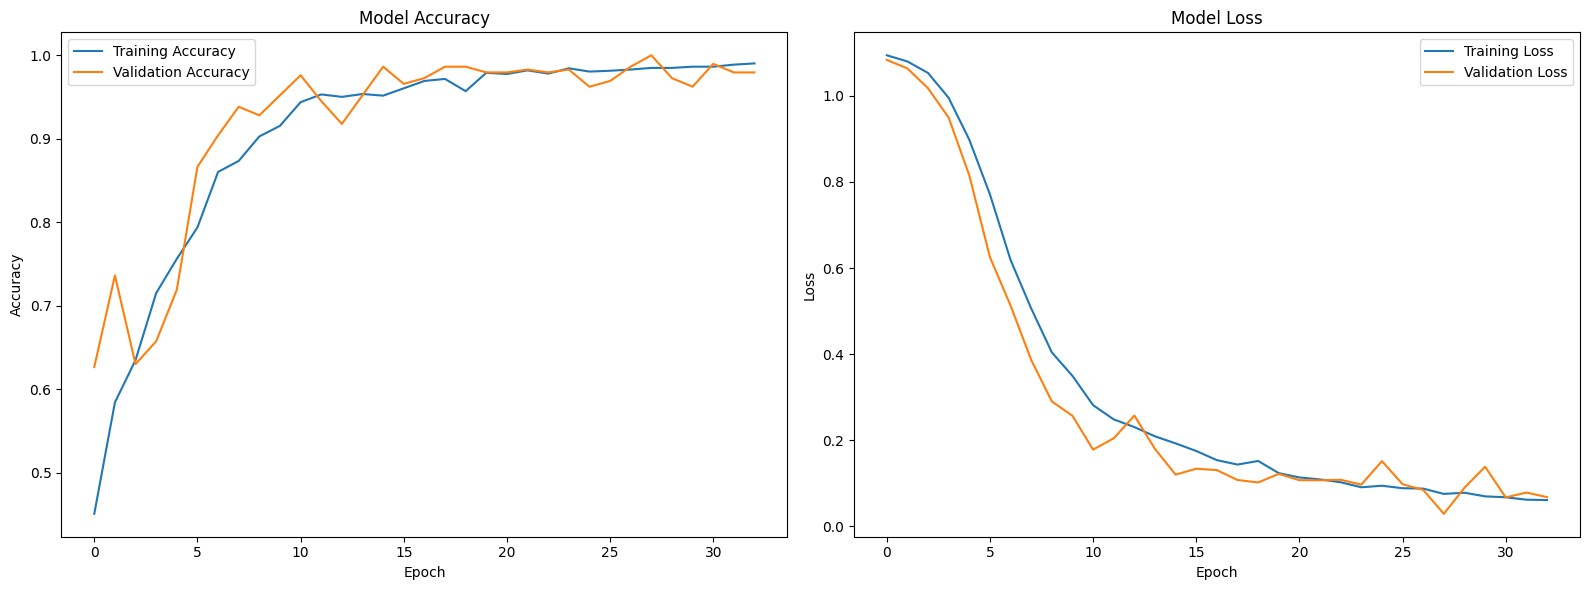

In [29]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(augmented_history.history['loss'], label='Training Loss')
plt.plot(augmented_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## CNN with L2 Regularization

In [30]:
l2_factor = 0.0001

regularized_model = tf.keras.models.Sequential()

regularized_model.add(tf.keras.Input(shape=input_shape))
regularized_model.add(layers.Rescaling(1./255))

regularized_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
regularized_model.add(layers.MaxPooling2D())

regularized_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
regularized_model.add(layers.MaxPooling2D())

regularized_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
regularized_model.add(layers.MaxPooling2D())

regularized_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
regularized_model.add(layers.MaxPooling2D())

regularized_model.add(layers.Flatten())

regularized_model.add(layers.Dense(512, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(l2_factor)))
regularized_model.add(layers.Dense(256, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(l2_factor)))
regularized_model.add(layers.Dense(128, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(l2_factor)))
regularized_model.add(layers.Dense(num_classes))

regularized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

regularized_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 80, 80, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,830,339 (14.61 MB)

 Trainable params: 3,830,339 (14.61 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
checkpoint_filepath = '/content/drive/MyDrive/regularized_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [32]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

regularized_start_time = time.time()
regularized_history = regularized_model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=100,
   callbacks=callback
)
regularized_end_time = time.time()
regularized_training_time = regularized_end_time - regularized_start_time
print(f"Regularized RGB model - Training took {regularized_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3562 - loss: 1.2418
Epoch 1: val_loss improved from inf to 1.23135, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.3564 - loss: 1.2417 - val_accuracy: 0.5582 - val_loss: 1.2314
Epoch 2/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6172 - loss: 1.2272
Epoch 2: val_loss improved from 1.23135 to 1.21831, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6165 - loss: 1.2270 - val_accuracy: 0.4966 - val_loss: 1.2183
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5495 - loss: 1.2116
Epoch 3: val_loss improved from 1.21831 to 1.20054, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5535 - loss: 1.2114 - val_accuracy: 0.6062 - val_loss: 1.2005
Epoch 4/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6309 - loss: 1.1894
Epoch 4: val_loss improved from 1.20054 to 1.17516, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6308 - loss: 1.1891 - val_accuracy: 0.5890 - val_loss: 1.1752
Epoch 5/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6437 - loss: 1.1580
Epoch 5: val_loss improved from 1.17516 to 1.12138, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6448 - loss: 1.1575 - val_accuracy: 0.6575 - val_loss: 1.1214
Epoch 6/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6775 - loss: 1.1154
Epoch 6: val_loss improved from 1.12138 to 1.05725, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6778 - loss: 1.1147 - val_accuracy: 0.7329 - val_loss: 1.0572
Epoch 7/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7001 - loss: 1.0609
Epoch 7: val_loss improved from 1.05725 to 0.98662, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7017 - loss: 1.0595 - val_accuracy: 0.8219 - val_loss: 0.9866
Epoch 8/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7795 - loss: 0.9755
Epoch 8: val_loss improved from 0.98662 to 0.90491, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7790 - loss: 0.9746 - val_accuracy: 0.8562 - val_loss: 0.9049
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8026 - loss: 0.8855
Epoch 9: val_loss improved from 0.90491 to 0.81929, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8027 - loss: 0.8853 - val_accuracy: 0.8014 - val_loss: 0.8193
Epoch 10/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8214 - loss: 0.8234
Epoch 10: val_loss improved from 0.81929 to 0.75660, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8229 - loss: 0.8211 - val_accuracy: 0.8459 - val_loss: 0.7566
Epoch 11/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8708 - loss: 0.7357
Epoch 11: val_loss improved from 0.75660 to 0.71715, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8710 - loss: 0.7344 - val_accuracy: 0.8733 - val_loss: 0.7172
Epoch 12/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8854 - loss: 0.6476
Epoch 12: val_loss improved from 0.71715 to 0.57391, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8861 - loss: 0.6465 - val_accuracy: 0.9418 - val_loss: 0.5739
Epoch 13/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9199 - loss: 0.5612
Epoch 13: val_loss improved from 0.57391 to 0.49728, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9202 - loss: 0.5605 - val_accuracy: 0.9418 - val_loss: 0.4973
Epoch 14/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9452 - loss: 0.5096
Epoch 14: val_loss improved from 0.49728 to 0.47499, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9452 - loss: 0.5086 - val_accuracy: 0.9692 - val_loss: 0.4750
Epoch 15/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9554 - loss: 0.4536
Epoch 15: val_loss improved from 0.47499 to 0.39069, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9555 - loss: 0.4528 - val_accuracy: 0.9692 - val_loss: 0.3907
Epoch 16/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9639 - loss: 0.4061
Epoch 16: val_loss improved from 0.39069 to 0.38249, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9639 - loss: 0.4058 - val_accuracy: 0.9623 - val_loss: 0.3825
Epoch 17/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9825 - loss: 0.3435
Epoch 17: val_loss improved from 0.38249 to 0.32868, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9823 - loss: 0.3443 - val_accuracy: 0.9829 - val_loss: 0.3287
Epoch 18/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9821 - loss: 0.3301
Epoch 18: val_loss improved from 0.32868 to 0.32161, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9820 - loss: 0.3301 - val_accuracy: 0.9795 - val_loss: 0.3216
Epoch 19/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9858 - loss: 0.3070
Epoch 19: val_loss improved from 0.32161 to 0.30380, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9852 - loss: 0.3069 - val_accuracy: 0.9932 - val_loss: 0.3038
Epoch 20/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9886 - loss: 0.2828
Epoch 20: val_loss improved from 0.30380 to 0.27193, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9885 - loss: 0.2827 - val_accuracy: 0.9897 - val_loss: 0.2719
Epoch 21/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9847 - loss: 0.2671
Epoch 21: val_loss improved from 0.27193 to 0.26592, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9848 - loss: 0.2669 - val_accuracy: 0.9760 - val_loss: 0.2659
Epoch 22/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9867 - loss: 0.2434
Epoch 22: val_loss improved from 0.26592 to 0.22423, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9865 - loss: 0.2438 - val_accuracy: 0.9966 - val_loss: 0.2242
Epoch 23/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9878 - loss: 0.2397
Epoch 23: val_loss improved from 0.22423 to 0.22101, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9877 - loss: 0.2398 - val_accuracy: 0.9966 - val_loss: 0.2210
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9909 - loss: 0.2230
Epoch 24: val_loss improved from 0.22101 to 0.20237, saving model to /content/drive/MyDrive/regularized_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9907 - loss: 0.2233 - val_accuracy: 0.9932 - val_loss: 0.2024
Epoch 25/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9922 - loss: 0.2114
Epoch 25: val_loss did not improve from 0.20237
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9921 - loss: 0.2115 - val_accuracy: 0.9932 - val_loss: 0.2212
Epoch 26/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9853 - loss: 0.2106
Epoch 26: val_loss did not improve from 0.20237
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9855 - loss: 0.2105 - val_accuracy: 0.9863 - val_loss: 0.2069
Epoch 27/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9888 - loss: 0.2001
Epoch 27: val_loss did not improve from 0.20237
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9889 - loss: 0.2000 - val_accuracy: 0.9863 - val_loss: 0.2073
Regularized RGB model - Training took 53.40 seconds


Learning rate at 3, since the accuracy converges quite quickly while the loss very steadily declines. Want to avoid going over too much epochs due to overfitting concerns

In [33]:
best_epoch_index = np.argmin(regularized_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = regularized_history.history['val_loss'][best_epoch_index]
best_val_accuracy = regularized_history.history['val_accuracy'][best_epoch_index]
best_training_loss = regularized_history.history['loss'][best_epoch_index]
best_training_accuracy = regularized_history.history['accuracy'][best_epoch_index]

print("Regularized Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {regularized_training_time:.2f} seconds")

Regularized Model Information:
Best Epoch: 24
Validation Loss: 0.202369
Validation Accuracy: 0.993151
Training Loss: 0.227963
Training Accuracy: 0.987787
Training Time: 53.40 seconds


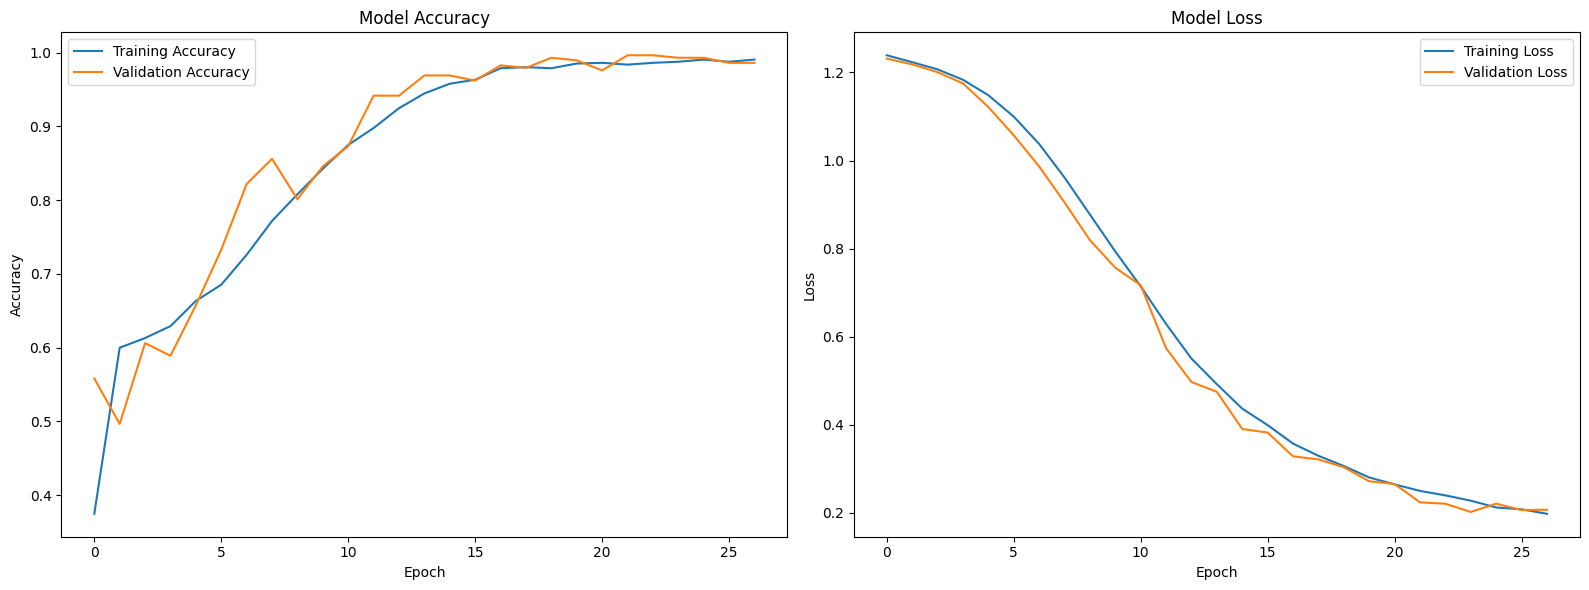

In [34]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(regularized_history.history['accuracy'], label='Training Accuracy')
plt.plot(regularized_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regularized_history.history['loss'], label='Training Loss')
plt.plot(regularized_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

Original deeper model a bit better - much lower training/validation loss

## CNN with Dropout

In [35]:
dropout_model = tf.keras.models.Sequential()

dropout_model.add(tf.keras.Input(shape=input_shape))
dropout_model.add(layers.Rescaling(1./255))

dropout_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
dropout_model.add(layers.MaxPooling2D())

dropout_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
dropout_model.add(layers.MaxPooling2D())

dropout_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
dropout_model.add(layers.MaxPooling2D())

dropout_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
dropout_model.add(layers.MaxPooling2D())

dropout_model.add(layers.Flatten())

dropout_model.add(layers.Dense(512, activation='relu'))
dropout_model.add(layers.Dropout(0.3))

dropout_model.add(layers.Dense(256, activation='relu'))
dropout_model.add(layers.Dropout(0.3))

dropout_model.add(layers.Dense(128, activation='relu'))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(num_classes))

dropout_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [36]:
checkpoint_filepath = '/content/drive/MyDrive/dropout_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [37]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

dropout_start_time = time.time()
dropout_history = dropout_model.fit(
   train_ds,
   validation_data=val_ds,
   epochs=100,
   callbacks=callback
)
dropout_end_time = time.time()
dropout_training_time = dropout_end_time - dropout_start_time
print(f"Dropout RGB model - Training took {dropout_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3452 - loss: 1.0966
Epoch 1: val_loss improved from inf to 1.09113, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.3452 - loss: 1.0966 - val_accuracy: 0.3870 - val_loss: 1.0911
Epoch 2/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3355 - loss: 1.0979
Epoch 2: val_loss improved from 1.09113 to 1.08216, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3369 - loss: 1.0977 - val_accuracy: 0.7021 - val_loss: 1.0822
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4136 - loss: 1.0849
Epoch 3: val_loss improved from 1.08216 to 1.06722, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4142 - loss: 1.0847 - val_accuracy: 0.6096 - val_loss: 1.0672
Epoch 4/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4600 - loss: 1.0697
Epoch 4: val_loss improved from 1.06722 to 1.04056, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4594 - loss: 1.0697 - val_accuracy: 0.6164 - val_loss: 1.0406
Epoch 5/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4864 - loss: 1.0579
Epoch 5: val_loss improved from 1.04056 to 1.00867, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4885 - loss: 1.0573 - val_accuracy: 0.6712 - val_loss: 1.0087
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5371 - loss: 1.0288
Epoch 6: val_loss improved from 1.00867 to 0.95376, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5383 - loss: 1.0282 - val_accuracy: 0.8288 - val_loss: 0.9538
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5815 - loss: 0.9820
Epoch 7: val_loss improved from 0.95376 to 0.90369, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5818 - loss: 0.9817 - val_accuracy: 0.6370 - val_loss: 0.9037
Epoch 8/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6329 - loss: 0.9184
Epoch 8: val_loss improved from 0.90369 to 0.76186, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6334 - loss: 0.9177 - val_accuracy: 0.8733 - val_loss: 0.7619
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6980 - loss: 0.8304
Epoch 9: val_loss improved from 0.76186 to 0.66623, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6984 - loss: 0.8296 - val_accuracy: 0.8596 - val_loss: 0.6662
Epoch 10/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7560 - loss: 0.7359
Epoch 10: val_loss improved from 0.66623 to 0.50893, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7564 - loss: 0.7342 - val_accuracy: 0.9212 - val_loss: 0.5089
Epoch 11/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7926 - loss: 0.6316
Epoch 11: val_loss improved from 0.50893 to 0.39165, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7935 - loss: 0.6298 - val_accuracy: 0.9726 - val_loss: 0.3916
Epoch 12/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8504 - loss: 0.5057
Epoch 12: val_loss improved from 0.39165 to 0.35443, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8506 - loss: 0.5044 - val_accuracy: 0.8938 - val_loss: 0.3544
Epoch 13/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8714 - loss: 0.4192
Epoch 13: val_loss improved from 0.35443 to 0.28225, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8717 - loss: 0.4186 - val_accuracy: 0.9418 - val_loss: 0.2823
Epoch 14/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9163 - loss: 0.3458
Epoch 14: val_loss improved from 0.28225 to 0.21453, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9162 - loss: 0.3449 - val_accuracy: 0.9795 - val_loss: 0.2145
Epoch 15/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9358 - loss: 0.2695
Epoch 15: val_loss improved from 0.21453 to 0.13726, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9359 - loss: 0.2687 - val_accuracy: 0.9932 - val_loss: 0.1373
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9491 - loss: 0.2230
Epoch 16: val_loss improved from 0.13726 to 0.12744, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9491 - loss: 0.2230 - val_accuracy: 0.9829 - val_loss: 0.1274
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9507 - loss: 0.1956
Epoch 17: val_loss did not improve from 0.12744
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9508 - loss: 0.1955 - val_accuracy: 0.9623 - val_loss: 0.1428
Epoch 18/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9596 - loss: 0.1743
Epoch 18: val_loss improved from 0.12744 to 0.10078, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9598 - loss: 0.1739 - val_accuracy: 0.9863 - val_loss: 0.1008
Epoch 19/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9706 - loss: 0.1511
Epoch 19: val_loss improved from 0.10078 to 0.07661, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9708 - loss: 0.1504 - val_accuracy: 0.9932 - val_loss: 0.0766
Epoch 20/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9790 - loss: 0.1245
Epoch 20: val_loss improved from 0.07661 to 0.05129, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9789 - loss: 0.1245 - val_accuracy: 0.9932 - val_loss: 0.0513
Epoch 21/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9831 - loss: 0.1017
Epoch 21: val_loss did not improve from 0.05129
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9831 - loss: 0.1016 - val_accuracy: 0.9863 - val_loss: 0.0673
Epoch 22/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9855 - loss: 0.0809
Epoch 22: val_loss improved from 0.05129 to 0.04601, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9855 - loss: 0.0812 - val_accuracy: 0.9932 - val_loss: 0.0460
Epoch 23/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9849 - loss: 0.0796
Epoch 23: val_loss improved from 0.04601 to 0.03035, saving model to /content/drive/MyDrive/dropout_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9850 - loss: 0.0800 - val_accuracy: 0.9966 - val_loss: 0.0303
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9913 - loss: 0.0819
Epoch 24: val_loss did not improve from 0.03035
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9911 - loss: 0.0815 - val_accuracy: 0.9932 - val_loss: 0.0537
Epoch 25/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9861 - loss: 0.0709
Epoch 25: val_loss did not improve from 0.03035
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9863 - loss: 0.0707 - val_accuracy: 0.9897 - val_loss: 0.0502
Epoch 26/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9913 - loss: 0.0685
Epoch 26: val_loss did not improve from 0.03035
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9913 - loss: 0.0684 - val_accuracy: 0.9932 - val_loss: 0.0342
Dropout RGB model - Training took 50.90 seconds


In [38]:
best_epoch_index = np.argmin(dropout_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = dropout_history.history['val_loss'][best_epoch_index]
best_val_accuracy = dropout_history.history['val_accuracy'][best_epoch_index]
best_training_loss = dropout_history.history['loss'][best_epoch_index]
best_training_accuracy = dropout_history.history['accuracy'][best_epoch_index]

print("Dropout Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {dropout_training_time:.2f} seconds")

Dropout Model Information:
Best Epoch: 23
Validation Loss: 0.030350
Validation Accuracy: 0.996575
Training Loss: 0.086504
Training Accuracy: 0.985344
Training Time: 50.90 seconds


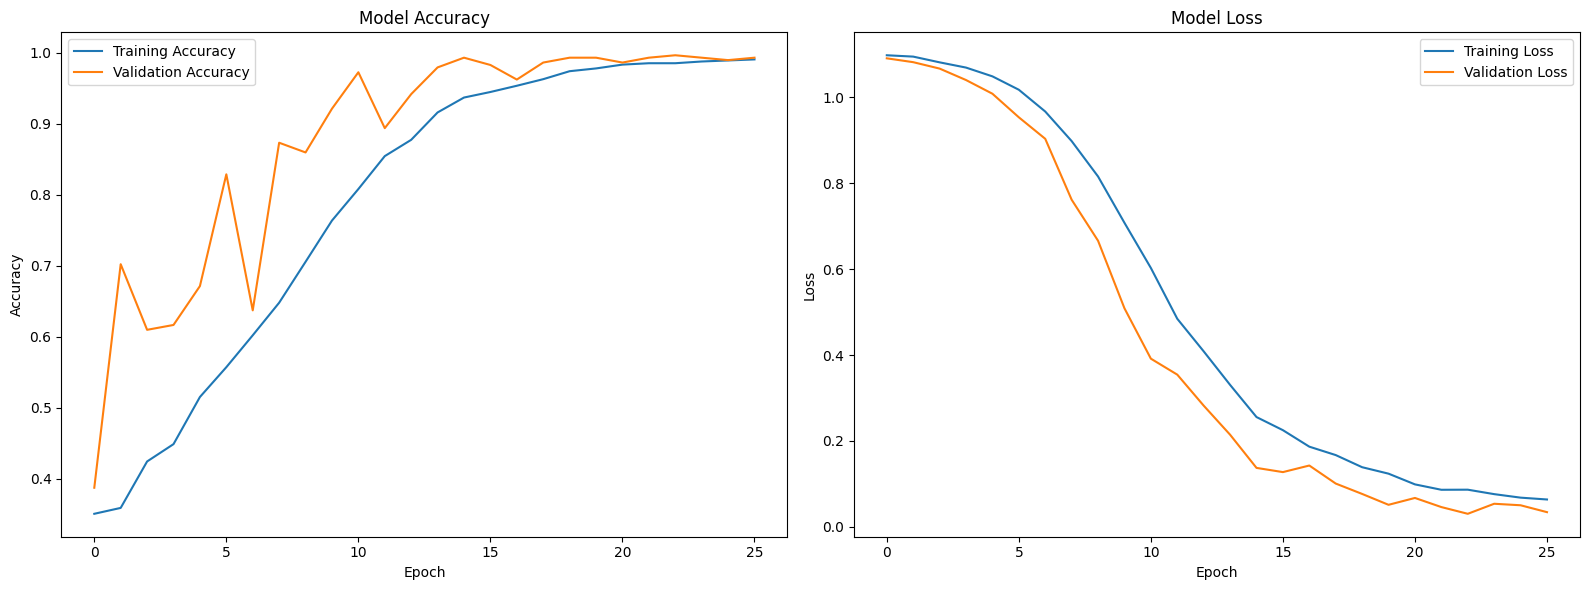

In [39]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(dropout_history.history['accuracy'], label='Training Accuracy')
plt.plot(dropout_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dropout_history.history['loss'], label='Training Loss')
plt.plot(dropout_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison

In [40]:
model_names = [
    'Basic CNN',
    'Deeper CNN',
    'Augmented CNN',
    'Regularized CNN',
    'Dropout CNN'
]

training_times = [
    training_time,
    deeper_training_time,
    augmented_training_time,
    regularized_training_time,
    dropout_training_time
]

best_val_accuracies = [
    history.history['val_accuracy'][np.argmin(history.history['val_loss'])],
    deeper_history.history['val_accuracy'][np.argmin(deeper_history.history['val_loss'])],
    augmented_history.history['val_accuracy'][np.argmin(augmented_history.history['val_loss'])],
    regularized_history.history['val_accuracy'][np.argmin(regularized_history.history['val_loss'])],
    dropout_history.history['val_accuracy'][np.argmin(dropout_history.history['val_loss'])]
]

best_val_losses = [
    history.history['val_loss'][np.argmin(history.history['val_loss'])],
    deeper_history.history['val_loss'][np.argmin(deeper_history.history['val_loss'])],
    augmented_history.history['val_loss'][np.argmin(augmented_history.history['val_loss'])],
    regularized_history.history['val_loss'][np.argmin(regularized_history.history['val_loss'])],
    dropout_history.history['val_loss'][np.argmin(dropout_history.history['val_loss'])]
]

model_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Training Time (s)': training_times,
    'Best Val. Accuracy': best_val_accuracies,
    'Best Val. Loss': best_val_losses
})

print(model_comparison_df)

             Model  Training Time (s)  Best Val. Accuracy  Best Val. Loss
0        Basic CNN          74.569648            1.000000        0.040553
1       Deeper CNN          59.246430            0.996575        0.014150
2    Augmented CNN          58.302574            1.000000        0.029228
3  Regularized CNN          53.400036            0.993151        0.202369
4      Dropout CNN          50.901451            0.996575        0.030350


In [41]:
fastest_model = model_comparison_df.loc[model_comparison_df['Training Time (s)'].idxmin()]['Model']
lowest_loss_model = model_comparison_df.loc[model_comparison_df['Best Val. Loss'].idxmin()]['Model']

print(f"\nFastest model: {fastest_model} ({model_comparison_df['Training Time (s)'].min():.2f} seconds)")
print(f"Model with lowest validation loss: {lowest_loss_model} ({model_comparison_df['Best Val. Loss'].min():.4f})")


Fastest model: Dropout CNN (50.90 seconds)
Model with lowest validation loss: Deeper CNN (0.0142)


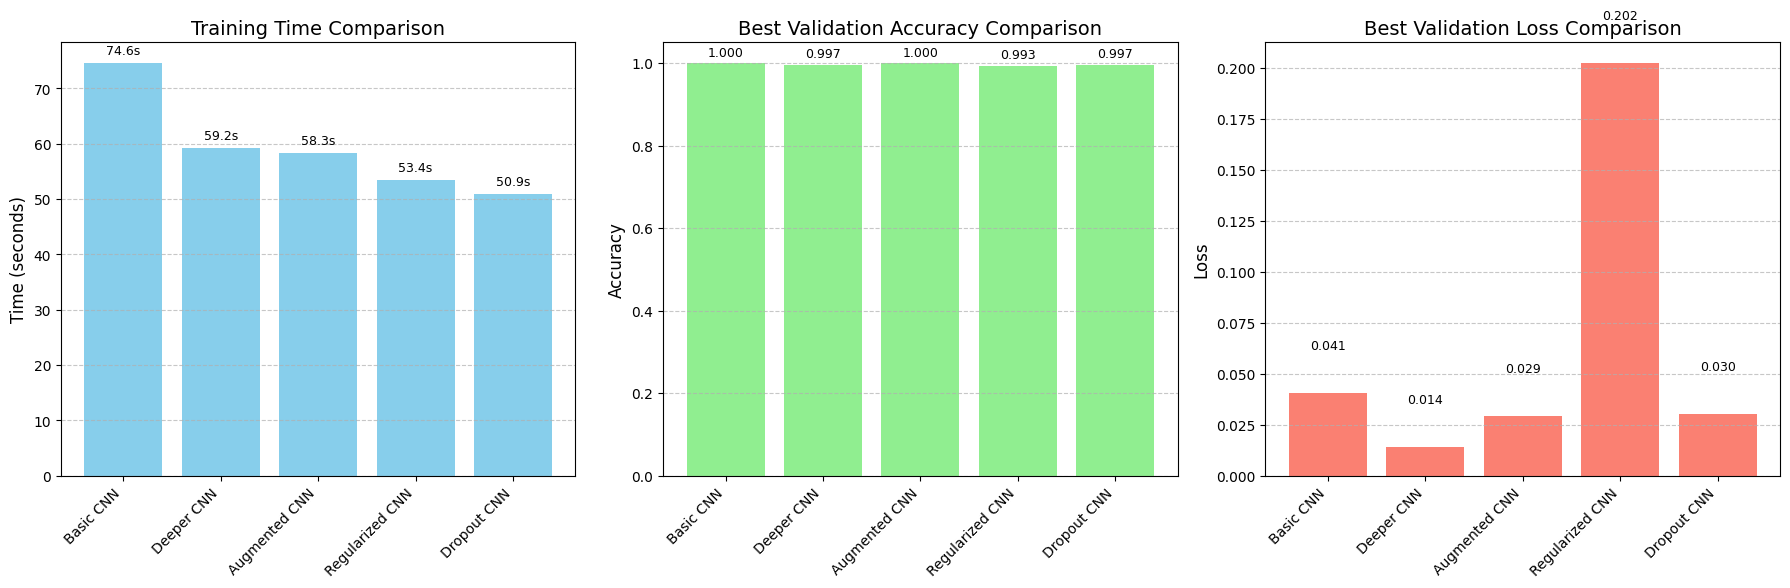

In [42]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
bars = plt.bar(model_names, training_times, color='skyblue')
plt.title('Training Time Comparison', fontsize=14)
plt.ylabel('Time (seconds)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}s', ha='center', va='bottom', fontsize=9)

plt.subplot(1, 3, 2)
bars = plt.bar(model_names, best_val_accuracies, color='lightgreen')
plt.title('Best Validation Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.subplot(1, 3, 3)
bars = plt.bar(model_names, best_val_losses, color='salmon')
plt.title('Best Validation Loss Comparison', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

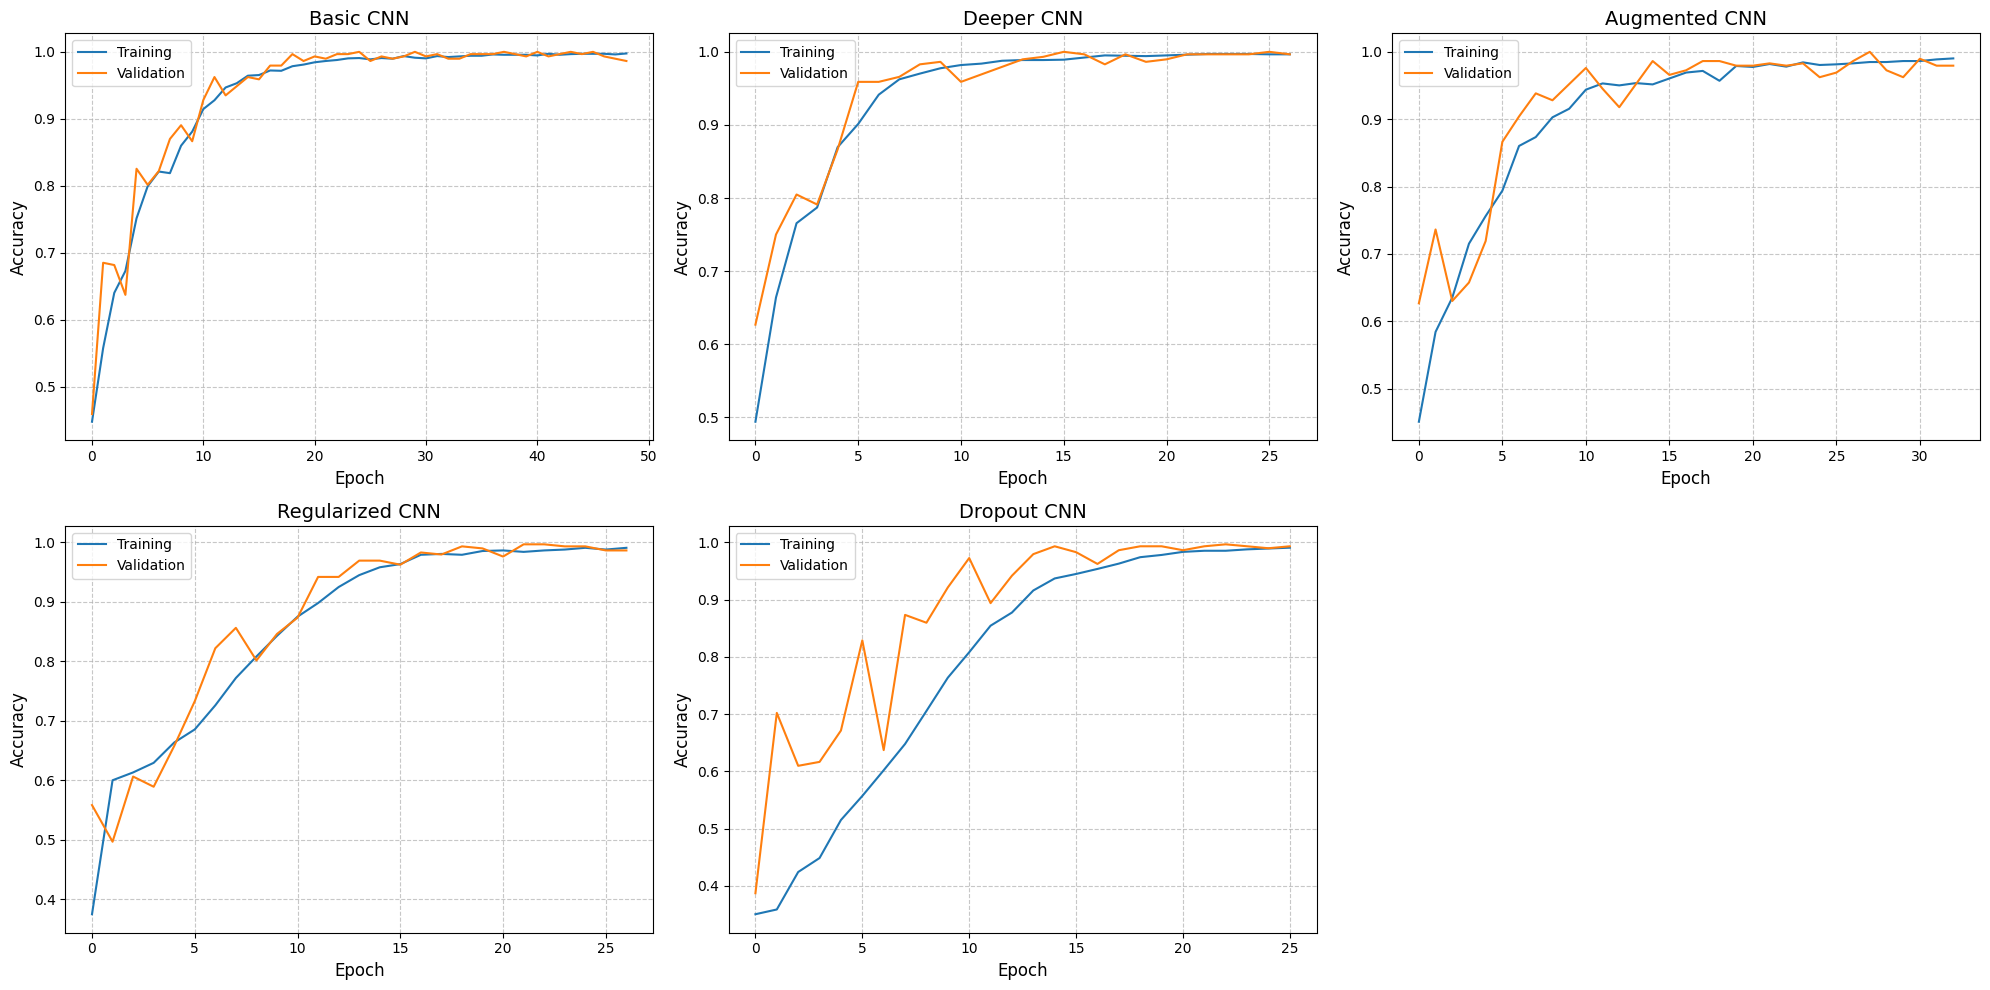

In [43]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Basic CNN', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(deeper_history.history['accuracy'], label='Training')
plt.plot(deeper_history.history['val_accuracy'], label='Validation')
plt.title('Deeper CNN', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(augmented_history.history['accuracy'], label='Training')
plt.plot(augmented_history.history['val_accuracy'], label='Validation')
plt.title('Augmented CNN', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(regularized_history.history['accuracy'], label='Training')
plt.plot(regularized_history.history['val_accuracy'], label='Validation')
plt.title('Regularized CNN', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(dropout_history.history['accuracy'], label='Training')
plt.plot(dropout_history.history['val_accuracy'], label='Validation')
plt.title('Dropout CNN', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

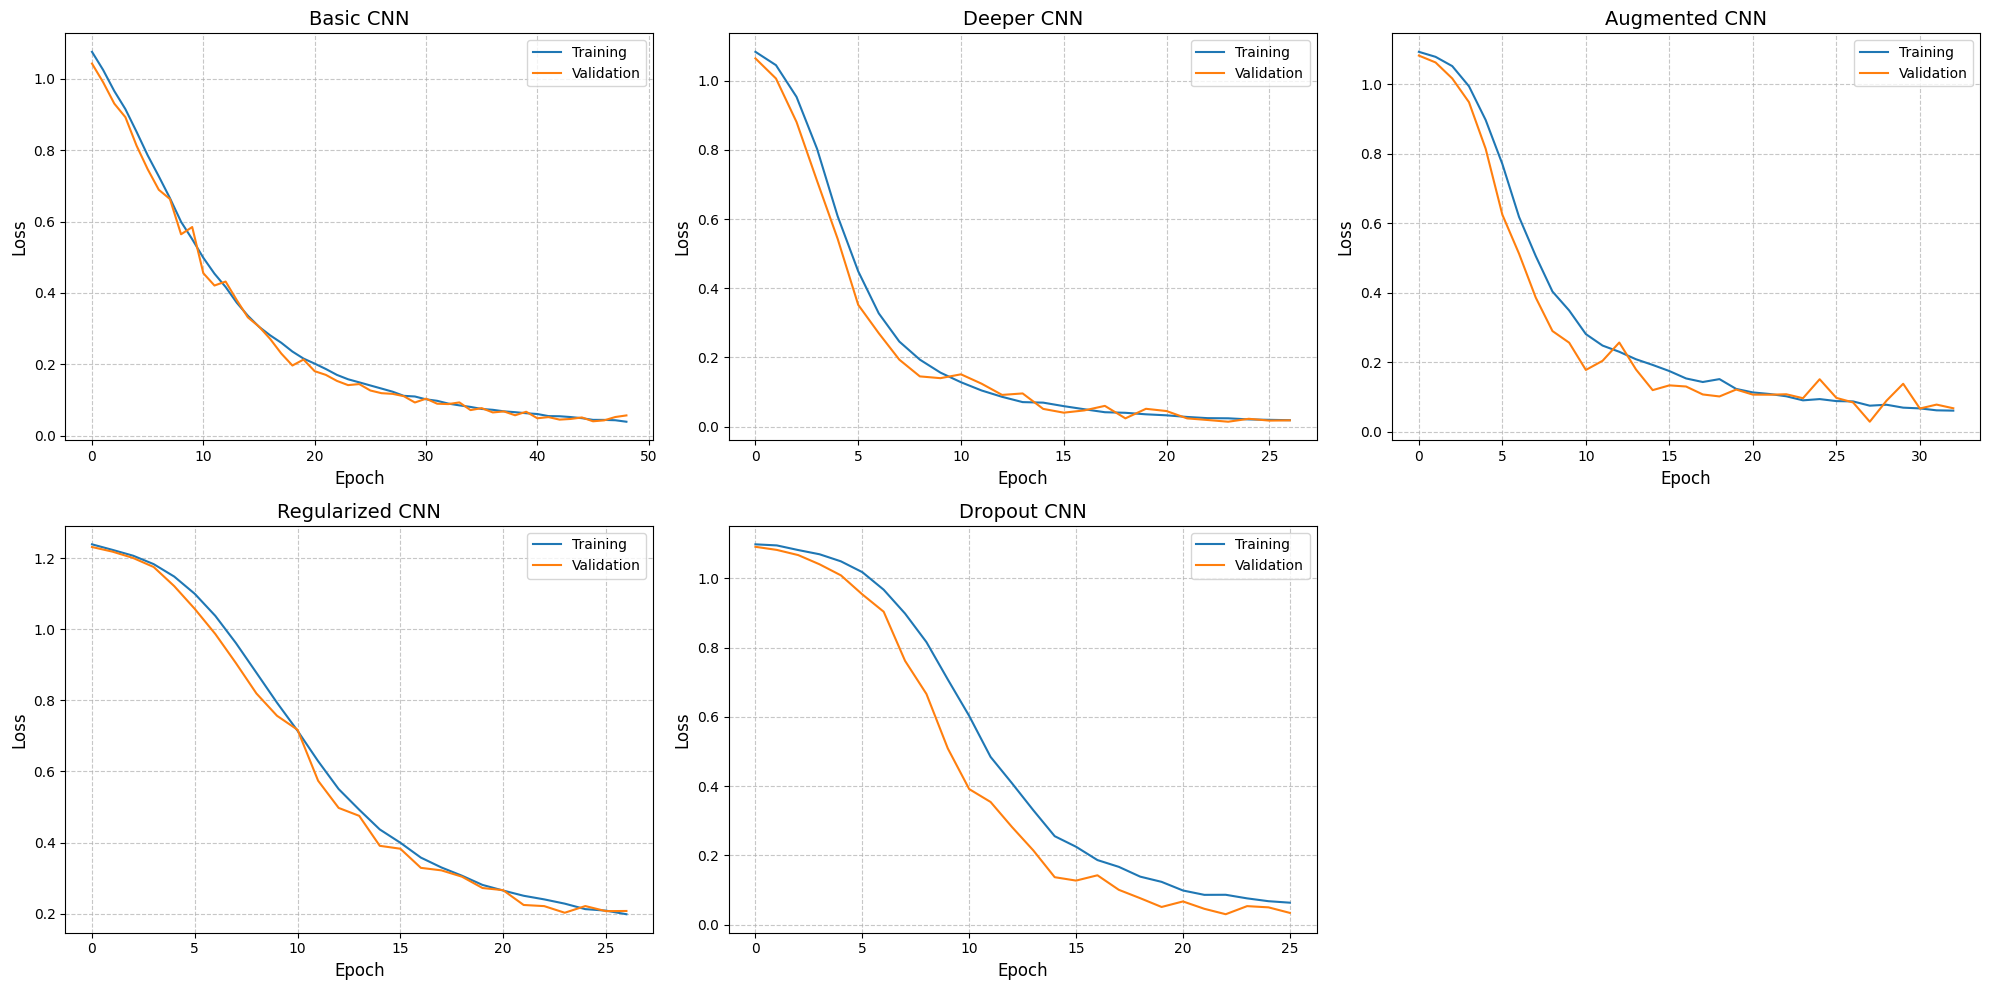

In [44]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Basic CNN', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(deeper_history.history['loss'], label='Training')
plt.plot(deeper_history.history['val_loss'], label='Validation')
plt.title('Deeper CNN', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(augmented_history.history['loss'], label='Training')
plt.plot(augmented_history.history['val_loss'], label='Validation')
plt.title('Augmented CNN', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(regularized_history.history['loss'], label='Training')
plt.plot(regularized_history.history['val_loss'], label='Validation')
plt.title('Regularized CNN', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(dropout_history.history['loss'], label='Training')
plt.plot(dropout_history.history['val_loss'], label='Validation')
plt.title('Dropout CNN', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('training_validation_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
def measure_inference_time(model, test_dataset, num_runs=5):
    def predict_batch():
        for image_batch, _ in test_dataset.take(1):
            _ = model.predict(image_batch)

    predict_batch()

    times = []
    for _ in range(num_runs):
        start_time = timeit.default_timer()
        for image_batch, _ in test_dataset:
            _ = model.predict(image_batch)
            break
        end_time = timeit.default_timer()
        times.append((end_time - start_time) * 1000)

    avg_time = np.mean(times)
    std_time = np.std(times)

    return avg_time, std_time

In [46]:
cnn_models = {
    'Basic CNN': model,
    'Deeper CNN': deeper_model,
    'Augmented CNN': augmented_model,
    'Regularized CNN': regularized_model,
    'Dropout CNN': dropout_model
}

prediction_models = {name: tf.keras.Sequential([model, tf.keras.layers.Softmax()])
                    for name, model in cnn_models.items()}

In [47]:
inference_results = {}

for name, model in prediction_models.items():
    print(f"Measuring inference time for {name}...")
    avg_time, std_time = measure_inference_time(model, test_ds)
    inference_results[name] = {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time
    }
    print(f"{name}: {avg_time:.2f}ms ± {std_time:.2f}ms per batch")

Measuring inference time for Basic CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Basic CNN: 681.13ms ± 6.67ms per batch
Measuring inference time for Deeper CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Deeper CNN: 686.41ms ± 27.62ms per batch
Measuring inference time for Augmented CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Augmented CNN: 672.19ms ± 7.94ms per batch
Measuring inference time for Regularized CNN...
1/1 ━━━━━━━

In [48]:
inference_df = pd.DataFrame([{
    'Model': name,
    'Avg Inference Time (ms)': results['avg_time_ms'],
    'Std Dev (ms)': results['std_time_ms']
} for name, results in inference_results.items()])

print("\nInference Time Results:")
print(inference_df)


Inference Time Results:
             Model  Avg Inference Time (ms)  Std Dev (ms)
0        Basic CNN               681.127880      6.671801
1       Deeper CNN               686.405431     27.619334
2    Augmented CNN               672.186897      7.936975
3  Regularized CNN               695.813579     28.744289
4      Dropout CNN               669.586407      2.206100


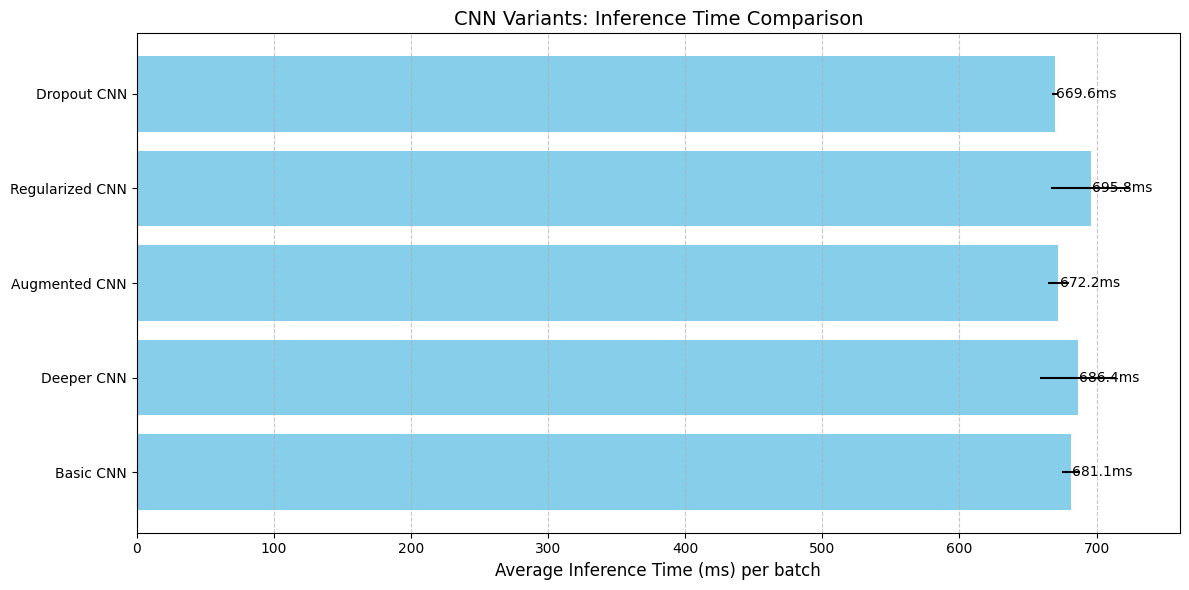

In [49]:
plt.figure(figsize=(12, 6))
bars = plt.barh(inference_df['Model'], inference_df['Avg Inference Time (ms)'],
         xerr=inference_df['Std Dev (ms)'], color='skyblue')
plt.title('CNN Variants: Inference Time Comparison', fontsize=14)
plt.xlabel('Average Inference Time (ms) per batch', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}ms', va='center')

plt.tight_layout()
plt.savefig('cnn_inference_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
cnn_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Training Time (s)': training_times,
    'Inference Time (ms)': [inference_results[model]['avg_time_ms'] for model in model_names],
    'Best Val. Accuracy': best_val_accuracies,
    'Best Val. Loss': best_val_losses
})

print("\nComprehensive CNN Model Comparison:")
print(cnn_comparison_df)


Comprehensive CNN Model Comparison:
             Model  Training Time (s)  Inference Time (ms)  \
0        Basic CNN          74.569648           681.127880   
1       Deeper CNN          59.246430           686.405431   
2    Augmented CNN          58.302574           672.186897   
3  Regularized CNN          53.400036           695.813579   
4      Dropout CNN          50.901451           669.586407   

   Best Val. Accuracy  Best Val. Loss  
0            1.000000        0.040553  
1            0.996575        0.014150  
2            1.000000        0.029228  
3            0.993151        0.202369  
4            0.996575        0.030350  


<ipython-input-51-eaed77904f74>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
<ipython-input-51-eaed77904f74>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
<ipython-input-51-eaed77904f74>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
<ipython-input-51-eaed77904f74>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')


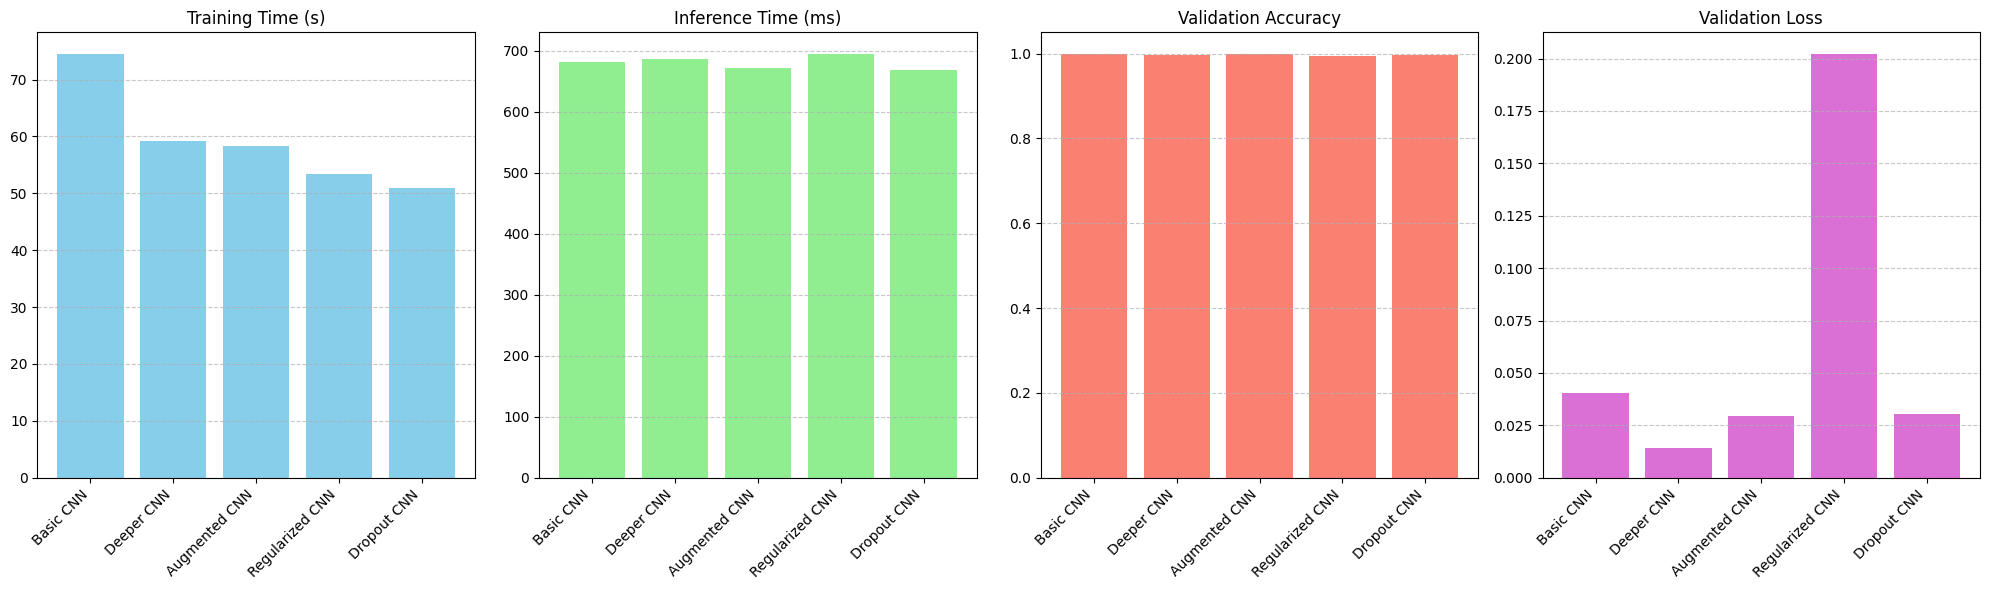

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

ax[0].bar(cnn_comparison_df['Model'], cnn_comparison_df['Training Time (s)'], color='skyblue')
ax[0].set_title('Training Time (s)')
ax[0].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1].bar(cnn_comparison_df['Model'], cnn_comparison_df['Inference Time (ms)'], color='lightgreen')
ax[1].set_title('Inference Time (ms)')
ax[1].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

ax[2].bar(cnn_comparison_df['Model'], cnn_comparison_df['Best Val. Accuracy'], color='salmon')
ax[2].set_title('Validation Accuracy')
ax[2].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
ax[2].grid(axis='y', linestyle='--', alpha=0.7)

ax[3].bar(cnn_comparison_df['Model'], cnn_comparison_df['Best Val. Loss'], color='orchid')
ax[3].set_title('Validation Loss')
ax[3].set_xticklabels(cnn_comparison_df['Model'], rotation=45, ha='right')
ax[3].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('cnn_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# CNNs with multiple image sizes


In [52]:
original_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

val_original_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'validation'),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

test_original_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    batch_size=None,
    shuffle=True,
    seed=seed_value
)

combined_original_ds = original_ds.concatenate(val_original_ds).concatenate(test_original_ds)

total_size = len(list(combined_original_ds))
train_size = int(0.7 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_original_ds = combined_original_ds.take(train_size)
temp_ds = combined_original_ds.skip(train_size)
val_original_ds = temp_ds.take(val_size)
test_original_ds = temp_ds.skip(val_size)

Found 2520 files belonging to 3 classes.
Found 33 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [53]:
resize_50 = tf.keras.layers.Resizing(50, 50)
resize_250 = tf.keras.layers.Resizing(250, 250)

small_input_shape = (50, 50, 3)
large_input_shape = (250, 250, 3)

train50_ds = train_original_ds.map(lambda x, y: (resize_50(x), y)).batch(batch_size)
val50_ds = val_original_ds.map(lambda x, y: (resize_50(x), y)).batch(batch_size)
test50_ds = test_original_ds.map(lambda x, y: (resize_50(x), y)).batch(batch_size)

train250_ds = train_original_ds.map(lambda x, y: (resize_250(x), y)).batch(batch_size)
val250_ds = val_original_ds.map(lambda x, y: (resize_250(x), y)).batch(batch_size)
test250_ds = test_original_ds.map(lambda x, y: (resize_250(x), y)).batch(batch_size)

In [54]:
train50_ds = train50_ds.prefetch(AUTOTUNE)
val50_ds = val50_ds.prefetch(AUTOTUNE)
test50_ds = test50_ds.prefetch(AUTOTUNE)

train300_ds = train250_ds.prefetch(AUTOTUNE)
val300_ds = val250_ds.prefetch(AUTOTUNE)
test300_ds = test250_ds.prefetch(AUTOTUNE)

## 50x50 Image Model

In [55]:
small_model = tf.keras.models.Sequential()

small_model.add(tf.keras.Input(shape=small_input_shape))
small_model.add(layers.Rescaling(1./255))

small_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
small_model.add(layers.MaxPooling2D())

small_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
small_model.add(layers.MaxPooling2D())

small_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
small_model.add(layers.MaxPooling2D())

small_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
small_model.add(layers.MaxPooling2D())

small_model.add(layers.Flatten())

small_model.add(layers.Dense(512, activation='relu'))
small_model.add(layers.Dense(256, activation='relu'))
small_model.add(layers.Dense(128, activation='relu'))
small_model.add(layers.Dense(num_classes))

small_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

small_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,187 (6.61 MB)

 Trainable params: 1,733,187 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
checkpoint_filepath = '/content/drive/MyDrive/small_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [57]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

small_start_time = time.time()
small_history = small_model.fit(
    train50_ds,
    validation_data=val50_ds,
    epochs=100,
    callbacks=callback
)
small_end_time = time.time()
small_training_time = small_end_time - small_start_time
print(f"50x50 image - Training took {small_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3869 - loss: 1.0922
Epoch 1: val_loss improved from inf to 1.07367, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.3876 - loss: 1.0921 - val_accuracy: 0.4863 - val_loss: 1.0737
Epoch 2/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5707 - loss: 1.0684
Epoch 2: val_loss improved from 1.07367 to 1.04214, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5743 - loss: 1.0679 - val_accuracy: 0.7500 - val_loss: 1.0421
Epoch 3/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6983 - loss: 1.0328
Epoch 3: val_loss improved from 1.04214 to 0.99159, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6978 - loss: 1.0325 - val_accuracy: 0.6644 - val_loss: 0.9916
Epoch 4/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6854 - loss: 0.9764
Epoch 4: val_loss improved from 0.99159 to 0.93885, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6860 - loss: 0.9757 - val_accuracy: 0.6541 - val_loss: 0.9389
Epoch 5/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7315 - loss: 0.9046
Epoch 5: val_loss improved from 0.93885 to 0.81207, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7331 - loss: 0.9030 - val_accuracy: 0.7705 - val_loss: 0.8121
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7745 - loss: 0.7995
Epoch 6: val_loss improved from 0.81207 to 0.73028, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7747 - loss: 0.7980 - val_accuracy: 0.8288 - val_loss: 0.7303
Epoch 7/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8397 - loss: 0.6902
Epoch 7: val_loss improved from 0.73028 to 0.59136, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8409 - loss: 0.6879 - val_accuracy: 0.8596 - val_loss: 0.5914
Epoch 8/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8844 - loss: 0.5482
Epoch 8: val_loss improved from 0.59136 to 0.47687, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8848 - loss: 0.5476 - val_accuracy: 0.9247 - val_loss: 0.4769
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9134 - loss: 0.4510
Epoch 9: val_loss improved from 0.47687 to 0.37907, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9133 - loss: 0.4498 - val_accuracy: 0.9315 - val_loss: 0.3791
Epoch 10/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9293 - loss: 0.3714
Epoch 10: val_loss improved from 0.37907 to 0.27435, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9304 - loss: 0.3697 - val_accuracy: 0.9589 - val_loss: 0.2743
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9497 - loss: 0.2924
Epoch 11: val_loss improved from 0.27435 to 0.24468, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9499 - loss: 0.2922 - val_accuracy: 0.9726 - val_loss: 0.2447
Epoch 12/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9769 - loss: 0.2292
Epoch 12: val_loss improved from 0.24468 to 0.22353, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9767 - loss: 0.2285 - val_accuracy: 0.9795 - val_loss: 0.2235
Epoch 13/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9879 - loss: 0.1766
Epoch 13: val_loss improved from 0.22353 to 0.16011, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9877 - loss: 0.1764 - val_accuracy: 0.9863 - val_loss: 0.1601
Epoch 14/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9866 - loss: 0.1455
Epoch 14: val_loss improved from 0.16011 to 0.14936, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9868 - loss: 0.1450 - val_accuracy: 0.9829 - val_loss: 0.1494
Epoch 15/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9884 - loss: 0.1237
Epoch 15: val_loss improved from 0.14936 to 0.10250, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9885 - loss: 0.1234 - val_accuracy: 0.9932 - val_loss: 0.1025
Epoch 16/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9856 - loss: 0.1051
Epoch 16: val_loss did not improve from 0.10250
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9857 - loss: 0.1050 - val_accuracy: 0.9829 - val_loss: 0.1106
Epoch 17/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9921 - loss: 0.0846
Epoch 17: val_loss improved from 0.10250 to 0.08861, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9921 - loss: 0.0848 - val_accuracy: 0.9932 - val_loss: 0.0886
Epoch 18/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9903 - loss: 0.0760
Epoch 18: val_loss improved from 0.08861 to 0.05370, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9904 - loss: 0.0759 - val_accuracy: 1.0000 - val_loss: 0.0537
Epoch 19/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9929 - loss: 0.0609
Epoch 19: val_loss did not improve from 0.05370
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9929 - loss: 0.0610 - val_accuracy: 0.9897 - val_loss: 0.0637
Epoch 20/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9955 - loss: 0.0605
Epoch 20: val_loss improved from 0.05370 to 0.04626, saving model to /content/drive/MyDrive/small_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9955 - loss: 0.0604 - val_accuracy: 0.9966 - val_loss: 0.0463
Epoch 21/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9939 - loss: 0.0505
Epoch 21: val_loss did not improve from 0.04626
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9938 - loss: 0.0507 - val_accuracy: 0.9932 - val_loss: 0.0592
Epoch 22/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9971 - loss: 0.0428
Epoch 22: val_loss did not improve from 0.04626
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9971 - loss: 0.0429 - val_accuracy: 0.9897 - val_loss: 0.0579
Epoch 23/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9920 - loss: 0.0492
Epoch 23: val_loss did not improve from 0.04626
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9921 - loss: 0.0489 - val_accuracy: 0.9795 - val_loss: 0.0688
50x50 image - Training took 49.63 seconds


In [58]:
best_epoch_index = np.argmin(small_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = small_history.history['val_loss'][best_epoch_index]
best_val_accuracy = small_history.history['val_accuracy'][best_epoch_index]
best_training_loss = small_history.history['loss'][best_epoch_index]
best_training_accuracy = small_history.history['accuracy'][best_epoch_index]

print("Small Model (50x50) Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {small_training_time:.2f} seconds")

Small Model (50x50) Information:
Best Epoch: 20
Validation Loss: 0.046262
Validation Accuracy: 0.996575
Training Loss: 0.059790
Training Accuracy: 0.994138
Training Time: 49.63 seconds


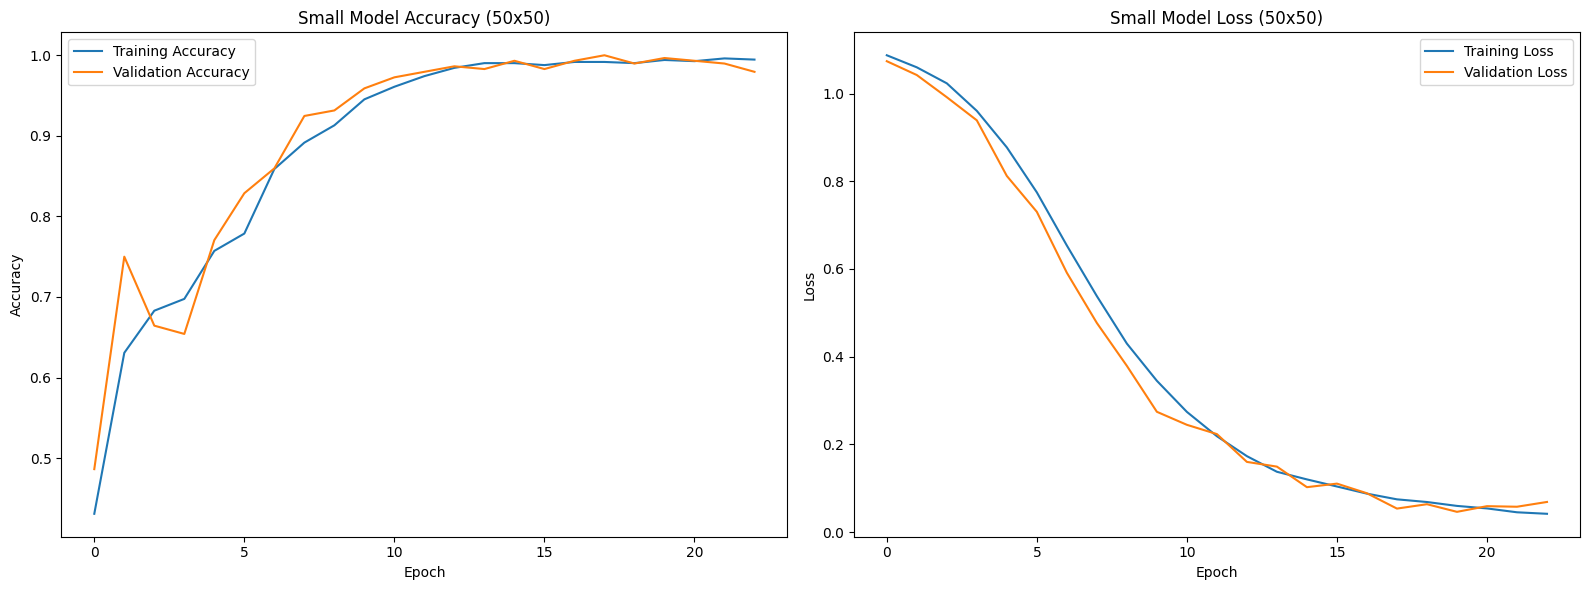

In [59]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(small_history.history['accuracy'], label='Training Accuracy')
plt.plot(small_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Small Model Accuracy (50x50)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(small_history.history['loss'], label='Training Loss')
plt.plot(small_history.history['val_loss'], label='Validation Loss')
plt.title('Small Model Loss (50x50)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 250x250 Image Model

In [60]:
large_model = tf.keras.models.Sequential()

large_model.add(tf.keras.Input(shape=large_input_shape))
large_model.add(layers.Rescaling(1./255))

large_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
large_model.add(layers.MaxPooling2D())

large_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
large_model.add(layers.MaxPooling2D())

large_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
large_model.add(layers.MaxPooling2D())

large_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
large_model.add(layers.MaxPooling2D())

large_model.add(layers.Flatten())

large_model.add(layers.Dense(512, activation='relu'))
large_model.add(layers.Dense(256, activation='relu'))
large_model.add(layers.Dense(128, activation='relu'))
large_model.add(layers.Dense(num_classes))

large_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

large_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 31, 31, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │    29,491,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,044,739 (114.61 MB)

 Trainable params: 30,044,739 (114.61 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
checkpoint_filepath = '/content/drive/MyDrive/large_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [62]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

large_start_time = time.time()
large_history = large_model.fit(
    train250_ds,
    validation_data=val250_ds,
    epochs=100,
    callbacks=callback
)
large_end_time = time.time()
large_training_time = large_end_time - large_start_time
print(f"250x250 image - Training took {large_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3665 - loss: 1.0929
Epoch 1: val_loss improved from inf to 1.07909, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.3673 - loss: 1.0928 - val_accuracy: 0.4247 - val_loss: 1.0791
Epoch 2/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4690 - loss: 1.0761
Epoch 2: val_loss improved from 1.07909 to 1.06547, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4701 - loss: 1.0760 - val_accuracy: 0.5479 - val_loss: 1.0655
Epoch 3/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5629 - loss: 1.0565
Epoch 3: val_loss improved from 1.06547 to 1.03580, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5641 - loss: 1.0562 - val_accuracy: 0.6507 - val_loss: 1.0358
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6225 - loss: 1.0316
Epoch 4: val_loss improved from 1.03580 to 1.02244, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6224 - loss: 1.0316 - val_accuracy: 0.7226 - val_loss: 1.0224
Epoch 5/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7190 - loss: 1.0108
Epoch 5: val_loss improved from 1.02244 to 0.98493, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7186 - loss: 1.0107 - val_accuracy: 0.7740 - val_loss: 0.9849
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7363 - loss: 0.9833
Epoch 6: val_loss improved from 0.98493 to 0.96371, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7359 - loss: 0.9832 - val_accuracy: 0.6781 - val_loss: 0.9637
Epoch 7/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6805 - loss: 0.9532
Epoch 7: val_loss improved from 0.96371 to 0.94104, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6820 - loss: 0.9528 - val_accuracy: 0.7842 - val_loss: 0.9410
Epoch 8/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7795 - loss: 0.9127
Epoch 8: val_loss improved from 0.94104 to 0.89265, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7781 - loss: 0.9126 - val_accuracy: 0.7158 - val_loss: 0.8927
Epoch 9/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7785 - loss: 0.8784
Epoch 9: val_loss improved from 0.89265 to 0.85615, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7784 - loss: 0.8784 - val_accuracy: 0.7568 - val_loss: 0.8562
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7860 - loss: 0.8444
Epoch 10: val_loss improved from 0.85615 to 0.81151, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7861 - loss: 0.8444 - val_accuracy: 0.8151 - val_loss: 0.8115
Epoch 11/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7745 - loss: 0.8011
Epoch 11: val_loss improved from 0.81151 to 0.75295, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7756 - loss: 0.8007 - val_accuracy: 0.7740 - val_loss: 0.7529
Epoch 12/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7910 - loss: 0.7704
Epoch 12: val_loss did not improve from 0.75295
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7927 - loss: 0.7694 - val_accuracy: 0.8048 - val_loss: 0.7546
Epoch 13/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8214 - loss: 0.7219
Epoch 13: val_loss improved from 0.75295 to 0.71801, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8214 - loss: 0.7219 - val_accuracy: 0.8630 - val_loss: 0.7180
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8472 - loss: 0.6829
Epoch 14: val_loss improved from 0.71801 to 0.67973, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8471 - loss: 0.6830 - val_accuracy: 0.8630 - val_loss: 0.6797
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8690 - loss: 0.6483
Epoch 15: val_loss improved from 0.67973 to 0.62220, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8688 - loss: 0.6483 - val_accuracy: 0.8904 - val_loss: 0.6222
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8704 - loss: 0.6206
Epoch 16: val_loss improved from 0.62220 to 0.59886, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8704 - loss: 0.6205 - val_accuracy: 0.8664 - val_loss: 0.5989
Epoch 17/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8728 - loss: 0.5942
Epoch 17: val_loss improved from 0.59886 to 0.58380, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8728 - loss: 0.5937 - val_accuracy: 0.8801 - val_loss: 0.5838
Epoch 18/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9005 - loss: 0.5567
Epoch 18: val_loss improved from 0.58380 to 0.52241, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8997 - loss: 0.5565 - val_accuracy: 0.8527 - val_loss: 0.5224
Epoch 19/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9038 - loss: 0.5187
Epoch 19: val_loss improved from 0.52241 to 0.48881, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9040 - loss: 0.5185 - val_accuracy: 0.9623 - val_loss: 0.4888
Epoch 20/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9359 - loss: 0.4991
Epoch 20: val_loss improved from 0.48881 to 0.45600, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9351 - loss: 0.4984 - val_accuracy: 0.8836 - val_loss: 0.4560
Epoch 21/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9181 - loss: 0.4502
Epoch 21: val_loss improved from 0.45600 to 0.43933, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9182 - loss: 0.4502 - val_accuracy: 0.8836 - val_loss: 0.4393
Epoch 22/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9311 - loss: 0.4315
Epoch 22: val_loss improved from 0.43933 to 0.39060, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9312 - loss: 0.4316 - val_accuracy: 0.9452 - val_loss: 0.3906
Epoch 23/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9455 - loss: 0.4105
Epoch 23: val_loss did not improve from 0.39060
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9455 - loss: 0.4105 - val_accuracy: 0.9521 - val_loss: 0.3963
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9542 - loss: 0.3909
Epoch 24: val_loss improved from 0.39060 to 0.35231, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9543 - loss: 0.3905 - val_accuracy: 0.9486 - val_loss: 0.3523
Epoch 25/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9547 - loss: 0.3632
Epoch 25: val_loss improved from 0.35231 to 0.31715, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9548 - loss: 0.3630 - val_accuracy: 0.9726 - val_loss: 0.3171
Epoch 26/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9572 - loss: 0.3463
Epoch 26: val_loss did not improve from 0.31715
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9577 - loss: 0.3456 - val_accuracy: 0.9795 - val_loss: 0.3252
Epoch 27/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9716 - loss: 0.3159
Epoch 27: val_loss improved from 0.31715 to 0.29177, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9715 - loss: 0.3158 - val_accuracy: 0.9623 - val_loss: 0.2918
Epoch 28/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9655 - loss: 0.3010
Epoch 28: val_loss improved from 0.29177 to 0.28541, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9654 - loss: 0.3010 - val_accuracy: 0.9692 - val_loss: 0.2854
Epoch 29/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9657 - loss: 0.2855
Epoch 29: val_loss improved from 0.28541 to 0.28322, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9657 - loss: 0.2855 - val_accuracy: 0.9863 - val_loss: 0.2832
Epoch 30/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9781 - loss: 0.2708
Epoch 30: val_loss improved from 0.28322 to 0.25265, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9779 - loss: 0.2706 - val_accuracy: 0.9692 - val_loss: 0.2527
Epoch 31/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9761 - loss: 0.2492
Epoch 31: val_loss improved from 0.25265 to 0.24513, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9761 - loss: 0.2493 - val_accuracy: 0.9760 - val_loss: 0.2451
Epoch 32/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9838 - loss: 0.2338
Epoch 32: val_loss improved from 0.24513 to 0.22563, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9837 - loss: 0.2339 - val_accuracy: 0.9692 - val_loss: 0.2256
Epoch 33/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9734 - loss: 0.2234
Epoch 33: val_loss improved from 0.22563 to 0.22358, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9734 - loss: 0.2233 - val_accuracy: 0.9863 - val_loss: 0.2236
Epoch 34/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9795 - loss: 0.2105
Epoch 34: val_loss improved from 0.22358 to 0.20437, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9794 - loss: 0.2105 - val_accuracy: 0.9863 - val_loss: 0.2044
Epoch 35/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9779 - loss: 0.2041
Epoch 35: val_loss improved from 0.20437 to 0.19159, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9781 - loss: 0.2039 - val_accuracy: 0.9897 - val_loss: 0.1916
Epoch 36/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9835 - loss: 0.1901
Epoch 36: val_loss improved from 0.19159 to 0.16152, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9836 - loss: 0.1901 - val_accuracy: 0.9897 - val_loss: 0.1615
Epoch 37/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9785 - loss: 0.1818
Epoch 37: val_loss improved from 0.16152 to 0.15984, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9786 - loss: 0.1817 - val_accuracy: 0.9897 - val_loss: 0.1598
Epoch 38/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9856 - loss: 0.1678
Epoch 38: val_loss did not improve from 0.15984
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9856 - loss: 0.1678 - val_accuracy: 0.9863 - val_loss: 0.1700
Epoch 39/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9856 - loss: 0.1610
Epoch 39: val_loss did not improve from 0.15984
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9856 - loss: 0.1610 - val_accuracy: 0.9863 - val_loss: 0.1612
Epoch 40/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9895 - loss: 0.1513
Epoch 40: val_loss improved from 0.15984 to 0.13890, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9894 - loss: 0.1513 - val_accuracy: 0.9932 - val_loss: 0.1389
Epoch 41/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9870 - loss: 0.1365
Epoch 41: val_loss improved from 0.13890 to 0.12366, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9869 - loss: 0.1366 - val_accuracy: 0.9966 - val_loss: 0.1237
Epoch 42/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9899 - loss: 0.1317
Epoch 42: val_loss did not improve from 0.12366
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9899 - loss: 0.1318 - val_accuracy: 0.9897 - val_loss: 0.1344
Epoch 43/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9860 - loss: 0.1268
Epoch 43: val_loss improved from 0.12366 to 0.12073, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9860 - loss: 0.1268 - val_accuracy: 0.9966 - val_loss: 0.1207
Epoch 44/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9885 - loss: 0.1197
Epoch 44: val_loss did not improve from 0.12073
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9885 - loss: 0.1197 - val_accuracy: 0.9932 - val_loss: 0.1208
Epoch 45/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9890 - loss: 0.1185
Epoch 45: val_loss improved from 0.12073 to 0.11407, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9891 - loss: 0.1184 - val_accuracy: 0.9897 - val_loss: 0.1141
Epoch 46/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9941 - loss: 0.1154
Epoch 46: val_loss did not improve from 0.11407
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9940 - loss: 0.1153 - val_accuracy: 0.9863 - val_loss: 0.1173
Epoch 47/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9900 - loss: 0.1055
Epoch 47: val_loss improved from 0.11407 to 0.10140, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9900 - loss: 0.1056 - val_accuracy: 0.9829 - val_loss: 0.1014
Epoch 48/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9906 - loss: 0.0976
Epoch 48: val_loss improved from 0.10140 to 0.09366, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9906 - loss: 0.0977 - val_accuracy: 1.0000 - val_loss: 0.0937
Epoch 49/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9916 - loss: 0.0967
Epoch 49: val_loss did not improve from 0.09366
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9916 - loss: 0.0966 - val_accuracy: 0.9932 - val_loss: 0.1002
Epoch 50/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9930 - loss: 0.0892
Epoch 50: val_loss improved from 0.09366 to 0.08159, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9928 - loss: 0.0893 - val_accuracy: 0.9966 - val_loss: 0.0816
Epoch 51/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9955 - loss: 0.0850
Epoch 51: val_loss did not improve from 0.08159
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9954 - loss: 0.0849 - val_accuracy: 0.9863 - val_loss: 0.0982
Epoch 52/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9887 - loss: 0.0829
Epoch 52: val_loss improved from 0.08159 to 0.06429, saving model to /content/drive/MyDrive/large_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9887 - loss: 0.0830 - val_accuracy: 1.0000 - val_loss: 0.0643
Epoch 53/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9905 - loss: 0.0792
Epoch 53: val_loss did not improve from 0.06429
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9906 - loss: 0.0792 - val_accuracy: 0.9932 - val_loss: 0.0952
Epoch 54/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9917 - loss: 0.0792
Epoch 54: val_loss did not improve from 0.06429
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9917 - loss: 0.0792 - val_accuracy: 0.9966 - val_loss: 0.0731
Epoch 55/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9925 - loss: 0.0720
Epoch 55: val_loss did not improve from 0.06429
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9925 - loss: 0.0718 - val_accuracy: 0.9932 - val_loss: 0.0716
250x250 image - Training took 166.19 seconds


In [63]:
best_epoch_index = np.argmin(large_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = large_history.history['val_loss'][best_epoch_index]
best_val_accuracy = large_history.history['val_accuracy'][best_epoch_index]
best_training_loss = large_history.history['loss'][best_epoch_index]
best_training_accuracy = large_history.history['accuracy'][best_epoch_index]

print("Large Model (250x250) Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {large_training_time:.2f} seconds")

Large Model (250x250) Information:
Best Epoch: 52
Validation Loss: 0.064294
Validation Accuracy: 1.000000
Training Loss: 0.083389
Training Accuracy: 0.989741
Training Time: 166.19 seconds


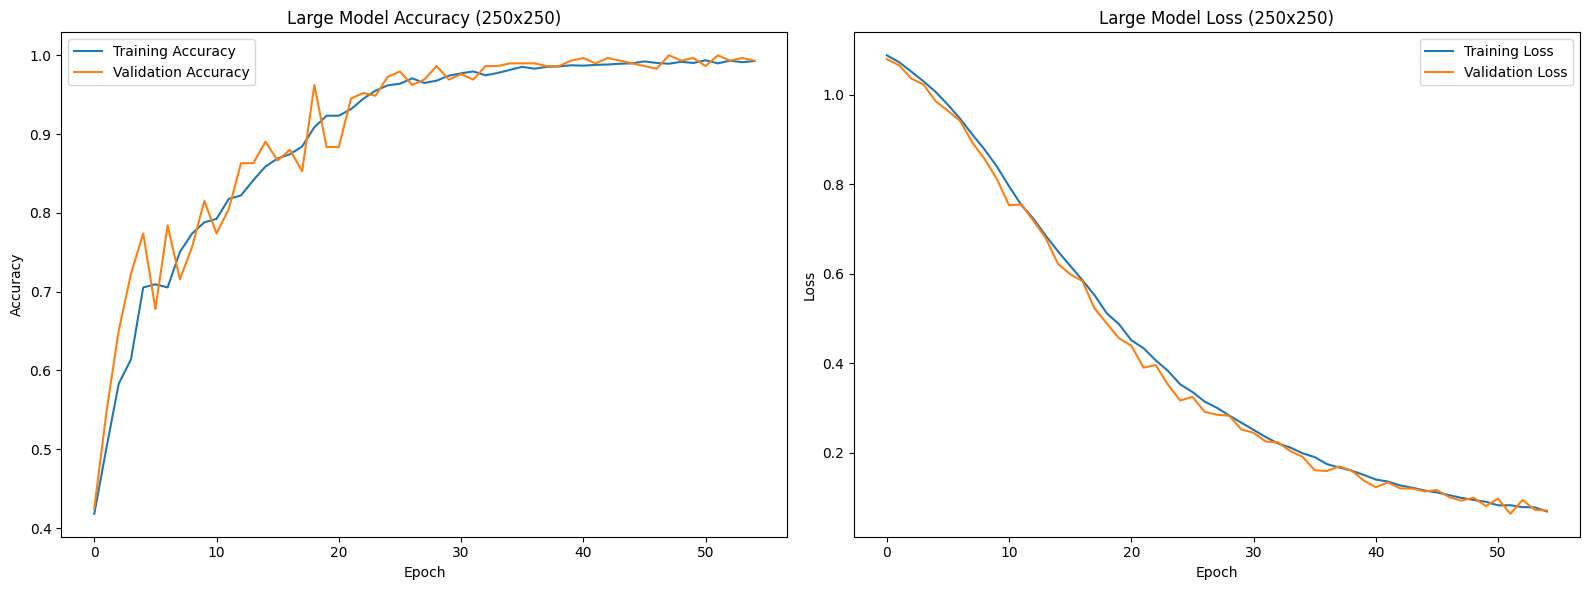

In [64]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(large_history.history['accuracy'], label='Training Accuracy')
plt.plot(large_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Large Model Accuracy (250x250)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(large_history.history['loss'], label='Training Loss')
plt.plot(large_history.history['val_loss'], label='Validation Loss')
plt.title('Large Model Loss (250x250)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison

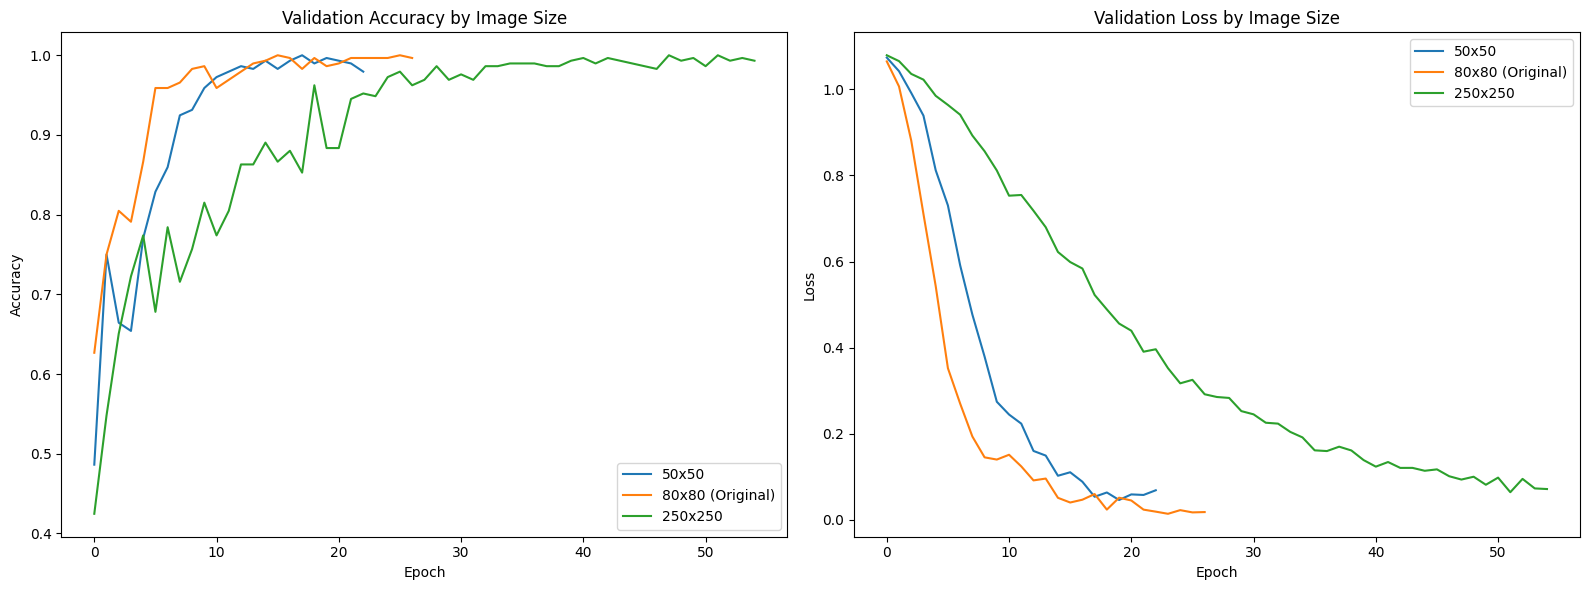

In [65]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(small_history.history['val_accuracy'], label='50x50')
plt.plot(deeper_history.history['val_accuracy'], label='80x80 (Original)')
plt.plot(large_history.history['val_accuracy'], label='250x250')
plt.title('Validation Accuracy by Image Size')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(small_history.history['val_loss'], label='50x50')
plt.plot(deeper_history.history['val_loss'], label='80x80 (Original)')
plt.plot(large_history.history['val_loss'], label='250x250')
plt.title('Validation Loss by Image Size')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
size_models = {
    'Deeper CNN (80x80)': deeper_model,
    'Small CNN (50x50)': small_model,
    'Large CNN (250x250)': large_model
}

test_data_mappings = {
    'Deeper CNN (80x80)': test_ds,
    'Small CNN (50x50)': test50_ds,
    'Large CNN (250x250)': test250_ds
}

prediction_models = {name: tf.keras.Sequential([model, tf.keras.layers.Softmax()])
                    for name, model in size_models.items()}

In [69]:
size_inference_results = {}

for name, model in prediction_models.items():
    print(f"Measuring inference time for {name}...")
    avg_time, std_time = measure_inference_time(model, test_data_mappings[name])
    size_inference_results[name] = {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time
    }
    print(f"{name}: {avg_time:.2f}ms ± {std_time:.2f}ms per batch")

Measuring inference time for Deeper CNN (80x80)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Deeper CNN (80x80): 765.22ms ± 57.20ms per batch
Measuring inference time for Small CNN (50x50)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Small CNN (50x50): 908.30ms ± 14.31ms per batch
Measuring inference time for Large CNN (250x250)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Large CNN (250x250): 919.36ms ± 34.70ms per batch


In [70]:
size_inference_df = pd.DataFrame([{
    'Model': name,
    'Avg Inference Time (ms)': results['avg_time_ms'],
    'Std Dev (ms)': results['std_time_ms']
} for name, results in size_inference_results.items()])

print("\nInference Time Results for Different Image Sizes:")
print(size_inference_df)


Inference Time Results for Different Image Sizes:
                 Model  Avg Inference Time (ms)  Std Dev (ms)
0   Deeper CNN (80x80)               765.219162     57.202103
1    Small CNN (50x50)               908.299837     14.306970
2  Large CNN (250x250)               919.362233     34.704571


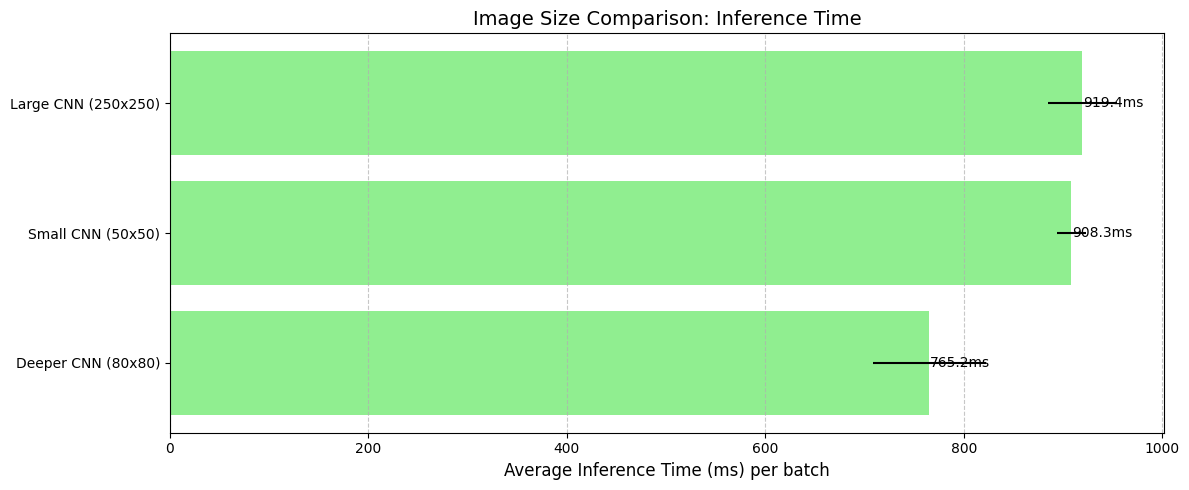

In [71]:
plt.figure(figsize=(12, 5))
bars = plt.barh(size_inference_df['Model'], size_inference_df['Avg Inference Time (ms)'],
         xerr=size_inference_df['Std Dev (ms)'], color='lightgreen')
plt.title('Image Size Comparison: Inference Time', fontsize=14)
plt.xlabel('Average Inference Time (ms) per batch', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}ms', va='center')

plt.tight_layout()
plt.savefig('image_size_inference_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
image_sizes = ['50x50', '80x80', '250x250']
model_names_for_sizes = ['Small CNN (50x50)', 'Deeper CNN (80x80)', 'Large CNN (250x250)']
training_times_for_sizes = [small_training_time, deeper_training_time, large_training_time]
inference_times_for_sizes = [size_inference_results[model]['avg_time_ms']
                            for model in model_names_for_sizes]
val_accs_for_sizes = [
    small_history.history['val_accuracy'][np.argmin(small_history.history['val_loss'])],
    deeper_history.history['val_accuracy'][np.argmin(deeper_history.history['val_loss'])],
    large_history.history['val_accuracy'][np.argmin(large_history.history['val_loss'])]
]
val_losses_for_sizes = [
    small_history.history['val_loss'][np.argmin(small_history.history['val_loss'])],
    deeper_history.history['val_loss'][np.argmin(deeper_history.history['val_loss'])],
    large_history.history['val_loss'][np.argmin(large_history.history['val_loss'])]
]

size_comparison_df = pd.DataFrame({
    'Image Size': image_sizes,
    'Model': model_names_for_sizes,
    'Training Time (s)': training_times_for_sizes,
    'Inference Time (ms)': inference_times_for_sizes,
    'Best Val. Accuracy': val_accs_for_sizes,
    'Best Val. Loss': val_losses_for_sizes
})

print("\nComprehensive Image Size Comparison:")
print(size_comparison_df)


Comprehensive Image Size Comparison:
  Image Size                Model  Training Time (s)  Inference Time (ms)  \
0      50x50    Small CNN (50x50)          49.629937           908.299837   
1      80x80   Deeper CNN (80x80)          59.246430           765.219162   
2    250x250  Large CNN (250x250)         166.191821           919.362233   

   Best Val. Accuracy  Best Val. Loss  
0            0.996575        0.046262  
1            0.996575        0.014150  
2            1.000000        0.064294  


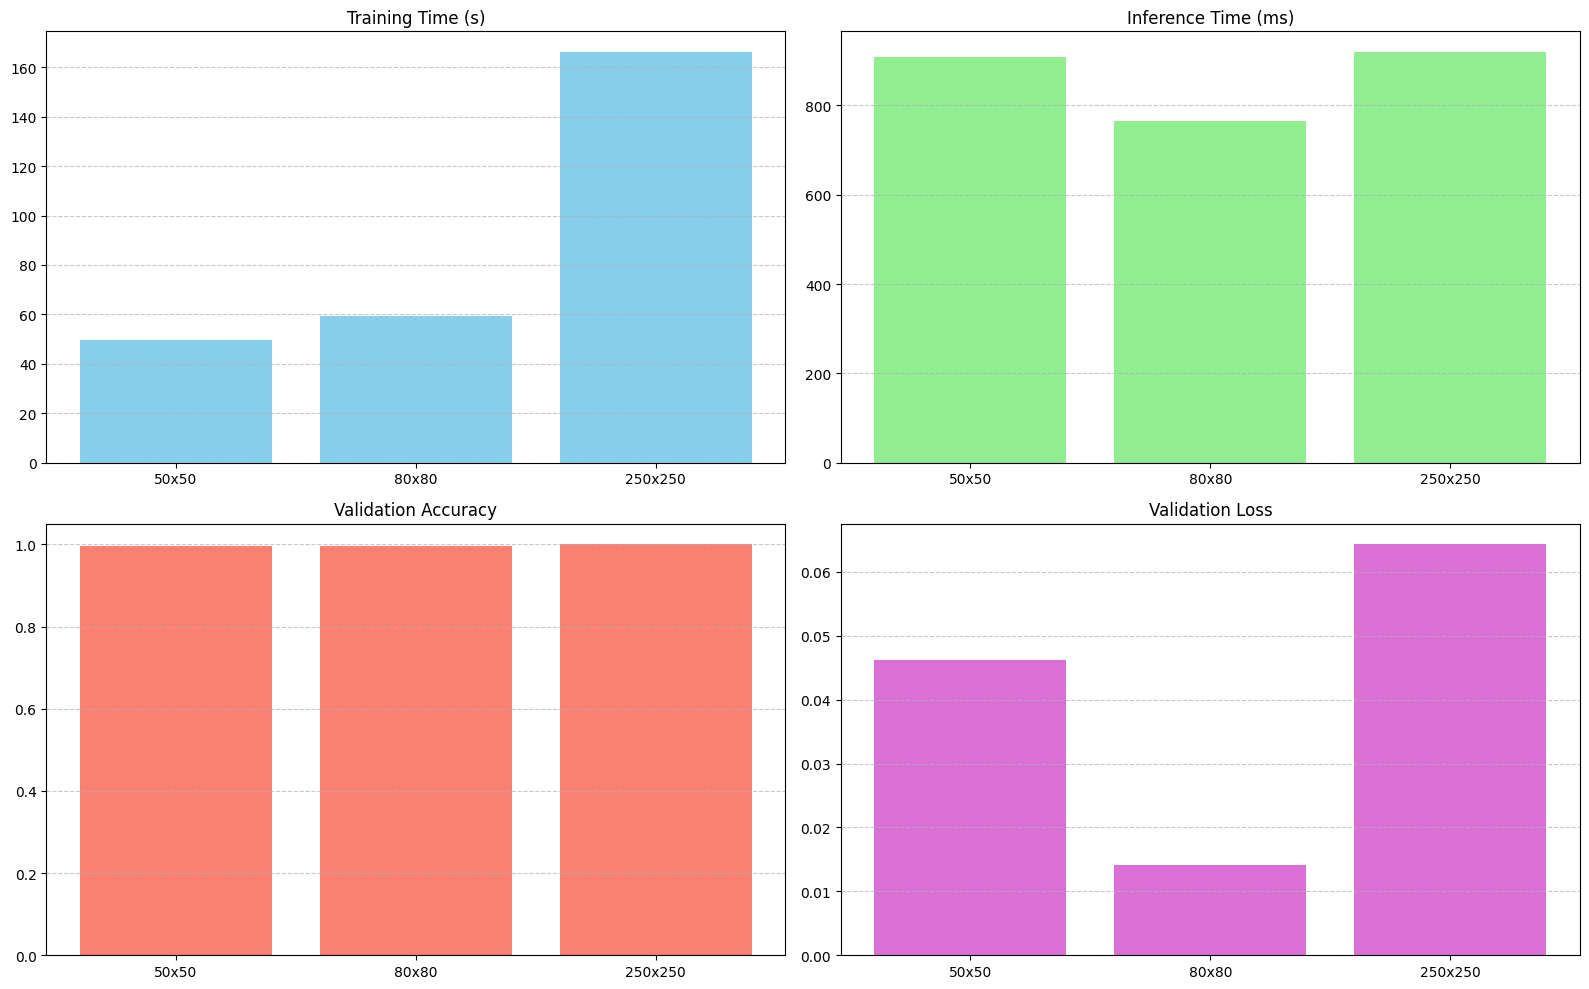

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0, 0].bar(size_comparison_df['Image Size'], size_comparison_df['Training Time (s)'], color='skyblue')
ax[0, 0].set_title('Training Time (s)')
ax[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[0, 1].bar(size_comparison_df['Image Size'], size_comparison_df['Inference Time (ms)'], color='lightgreen')
ax[0, 1].set_title('Inference Time (ms)')
ax[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 0].bar(size_comparison_df['Image Size'], size_comparison_df['Best Val. Accuracy'], color='salmon')
ax[1, 0].set_title('Validation Accuracy')
ax[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 1].bar(size_comparison_df['Image Size'], size_comparison_df['Best Val. Loss'], color='orchid')
ax[1, 1].set_title('Validation Loss')
ax[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('image_size_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison to Greyscale

In [74]:
def convert_batch_to_grayscale(images, labels):
    grayscale = tf.image.rgb_to_grayscale(images)
    return grayscale, labels


In [75]:
grayscale_train_ds = train_ds.map(convert_batch_to_grayscale)
grayscale_val_ds = val_ds.map(convert_batch_to_grayscale)
grayscale_test_ds = test_ds.map(convert_batch_to_grayscale)

In [76]:
grayscale_train_ds = grayscale_train_ds.prefetch(AUTOTUNE)
grayscale_val_ds = grayscale_val_ds.prefetch(AUTOTUNE)
grayscale_test_ds = grayscale_test_ds.prefetch(AUTOTUNE)

Sample grayscale images from the training set:


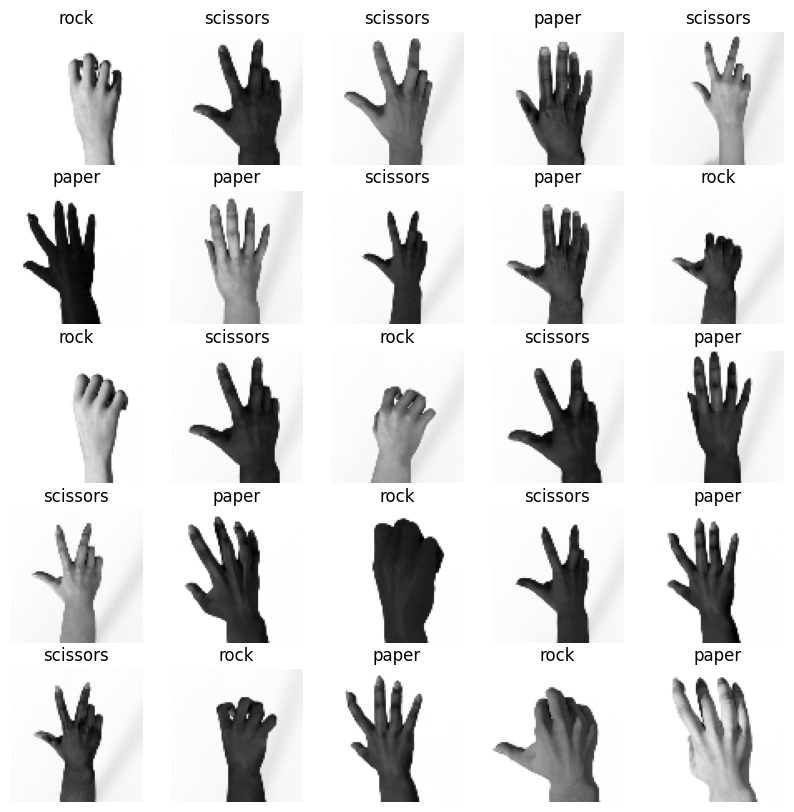

In [77]:
def display_grayscale_images(dataset, num_images=25):
    plt.figure(figsize=(10, 10))
    batch_images, batch_labels = next(iter(dataset.take(1)))

    display_count = min(num_images, batch_images.shape[0])

    for i in range(display_count):
        ax = plt.subplot(5, 5, i + 1)
        grayscale_image = tf.squeeze(batch_images[i])
        plt.imshow(grayscale_image.numpy().astype("uint8"), cmap='gray')

        label_index = batch_labels[i].numpy()
        plt.title(class_names[label_index])
        plt.axis("off")
    plt.show()

print("Sample grayscale images from the training set:")
display_grayscale_images(grayscale_train_ds)

In [78]:
grayscale_input_shape = (image_size, image_size, 1)

gray_deeper_model = tf.keras.models.Sequential()

gray_deeper_model.add(tf.keras.Input(shape=grayscale_input_shape))
gray_deeper_model.add(layers.Rescaling(1./255))

gray_deeper_model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
gray_deeper_model.add(layers.MaxPooling2D())

gray_deeper_model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
gray_deeper_model.add(layers.MaxPooling2D())

gray_deeper_model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
gray_deeper_model.add(layers.MaxPooling2D())

gray_deeper_model.add(layers.Conv2D(256, 3, padding='same', activation='relu'))
gray_deeper_model.add(layers.MaxPooling2D())

gray_deeper_model.add(layers.Flatten())

gray_deeper_model.add(layers.Dense(512, activation='relu'))
gray_deeper_model.add(layers.Dense(256, activation='relu'))
gray_deeper_model.add(layers.Dense(128, activation='relu'))
gray_deeper_model.add(layers.Dense(num_classes))

gray_deeper_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

gray_deeper_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 80, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,829,763 (14.61 MB)

 Trainable params: 3,829,763 (14.61 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
checkpoint_filepath = '/content/drive/MyDrive/gray_deeper_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [80]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

gray_deeper_start_time = time.time()
gray_deeper_history = gray_deeper_model.fit(
    grayscale_train_ds,
    validation_data=grayscale_val_ds,
    epochs=100,
    callbacks=callback
)
gray_deeper_end_time = time.time()
gray_deeper_training_time = gray_deeper_end_time - gray_deeper_start_time
print(f"Grayscale Deeper CNN model - Training took {gray_deeper_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3748 - loss: 1.0933
Epoch 1: val_loss improved from inf to 1.08038, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 224ms/step - accuracy: 0.3755 - loss: 1.0932 - val_accuracy: 0.4281 - val_loss: 1.0804
Epoch 2/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4627 - loss: 1.0714
Epoch 2: val_loss improved from 1.08038 to 1.04657, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4668 - loss: 1.0711 - val_accuracy: 0.6678 - val_loss: 1.0466
Epoch 3/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6414 - loss: 1.0394
Epoch 3: val_loss improved from 1.04657 to 1.00717, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6420 - loss: 1.0391 - val_accuracy: 0.6575 - val_loss: 1.0072
Epoch 4/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7663 - loss: 0.9788
Epoch 4: val_loss improved from 1.00717 to 0.90687, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7640 - loss: 0.9771 - val_accuracy: 0.7432 - val_loss: 0.9069
Epoch 5/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6852 - loss: 0.8802
Epoch 5: val_loss improved from 0.90687 to 0.74678, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6871 - loss: 0.8784 - val_accuracy: 0.7911 - val_loss: 0.7468
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8053 - loss: 0.7429
Epoch 6: val_loss improved from 0.74678 to 0.65139, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8059 - loss: 0.7411 - val_accuracy: 0.8630 - val_loss: 0.6514
Epoch 7/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8566 - loss: 0.5866
Epoch 7: val_loss improved from 0.65139 to 0.50341, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8560 - loss: 0.5860 - val_accuracy: 0.8733 - val_loss: 0.5034
Epoch 8/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8895 - loss: 0.4793
Epoch 8: val_loss improved from 0.50341 to 0.39069, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8897 - loss: 0.4778 - val_accuracy: 0.9486 - val_loss: 0.3907
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9202 - loss: 0.3785
Epoch 9: val_loss improved from 0.39069 to 0.32156, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9199 - loss: 0.3778 - val_accuracy: 0.9486 - val_loss: 0.3216
Epoch 10/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9427 - loss: 0.3008
Epoch 10: val_loss improved from 0.32156 to 0.27021, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9429 - loss: 0.3006 - val_accuracy: 0.9452 - val_loss: 0.2702
Epoch 11/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9642 - loss: 0.2463
Epoch 11: val_loss improved from 0.27021 to 0.21220, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9640 - loss: 0.2458 - val_accuracy: 0.9623 - val_loss: 0.2122
Epoch 12/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9633 - loss: 0.2047
Epoch 12: val_loss improved from 0.21220 to 0.18637, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9639 - loss: 0.2042 - val_accuracy: 0.9726 - val_loss: 0.1864
Epoch 13/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9807 - loss: 0.1702
Epoch 13: val_loss improved from 0.18637 to 0.15438, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9807 - loss: 0.1700 - val_accuracy: 0.9795 - val_loss: 0.1544
Epoch 14/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9855 - loss: 0.1327
Epoch 14: val_loss improved from 0.15438 to 0.11771, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9853 - loss: 0.1329 - val_accuracy: 0.9863 - val_loss: 0.1177
Epoch 15/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.1231
Epoch 15: val_loss improved from 0.11771 to 0.09174, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9824 - loss: 0.1229 - val_accuracy: 0.9932 - val_loss: 0.0917
Epoch 16/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9919 - loss: 0.0928
Epoch 16: val_loss did not improve from 0.09174
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9918 - loss: 0.0932 - val_accuracy: 0.9829 - val_loss: 0.1152
Epoch 17/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9849 - loss: 0.1005
Epoch 17: val_loss improved from 0.09174 to 0.07380, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9850 - loss: 0.1002 - val_accuracy: 0.9966 - val_loss: 0.0738
Epoch 18/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9881 - loss: 0.0864
Epoch 18: val_loss did not improve from 0.07380
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9882 - loss: 0.0861 - val_accuracy: 1.0000 - val_loss: 0.0845
Epoch 19/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9944 - loss: 0.0739
Epoch 19: val_loss improved from 0.07380 to 0.06502, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9944 - loss: 0.0737 - val_accuracy: 0.9863 - val_loss: 0.0650
Epoch 20/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9901 - loss: 0.0640
Epoch 20: val_loss did not improve from 0.06502
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9901 - loss: 0.0640 - val_accuracy: 0.9829 - val_loss: 0.0766
Epoch 21/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9942 - loss: 0.0509
Epoch 21: val_loss improved from 0.06502 to 0.04368, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9941 - loss: 0.0510 - val_accuracy: 1.0000 - val_loss: 0.0437
Epoch 22/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9955 - loss: 0.0460
Epoch 22: val_loss improved from 0.04368 to 0.03831, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9954 - loss: 0.0462 - val_accuracy: 0.9932 - val_loss: 0.0383
Epoch 23/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9946 - loss: 0.0504
Epoch 23: val_loss did not improve from 0.03831
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9946 - loss: 0.0501 - val_accuracy: 0.9966 - val_loss: 0.0410
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9952 - loss: 0.0443
Epoch 24: val_loss improved from 0.03831 to 0.02675, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9952 - loss: 0.0444 - val_accuracy: 1.0000 - val_loss: 0.0267
Epoch 25/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0279
Epoch 25: val_loss did not improve from 0.02675
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9967 - loss: 0.0285 - val_accuracy: 0.9932 - val_loss: 0.0319
Epoch 26/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9973 - loss: 0.0288
Epoch 26: val_loss did not improve from 0.02675
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9972 - loss: 0.0291 - val_accuracy: 0.9966 - val_loss: 0.0314
Epoch 27/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9974 - loss: 0.0289
Epoch 27: val_loss did not improve from 0.02675
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9972 - loss: 0.0293 - val_accuracy: 0.9966 - val_loss: 0.0303
Grayscale Deeper CNN model - Training took 56.18 seconds


In [81]:
best_epoch_index = np.argmin(gray_deeper_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = gray_deeper_history.history['val_loss'][best_epoch_index]
best_val_accuracy = gray_deeper_history.history['val_accuracy'][best_epoch_index]
best_training_loss = gray_deeper_history.history['loss'][best_epoch_index]
best_training_accuracy = gray_deeper_history.history['accuracy'][best_epoch_index]

print("Grayscale Deeper Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {gray_deeper_training_time:.2f} seconds")

Grayscale Deeper Model Information:
Best Epoch: 24
Validation Loss: 0.026750
Validation Accuracy: 1.000000
Training Loss: 0.044520
Training Accuracy: 0.994626
Training Time: 56.18 seconds


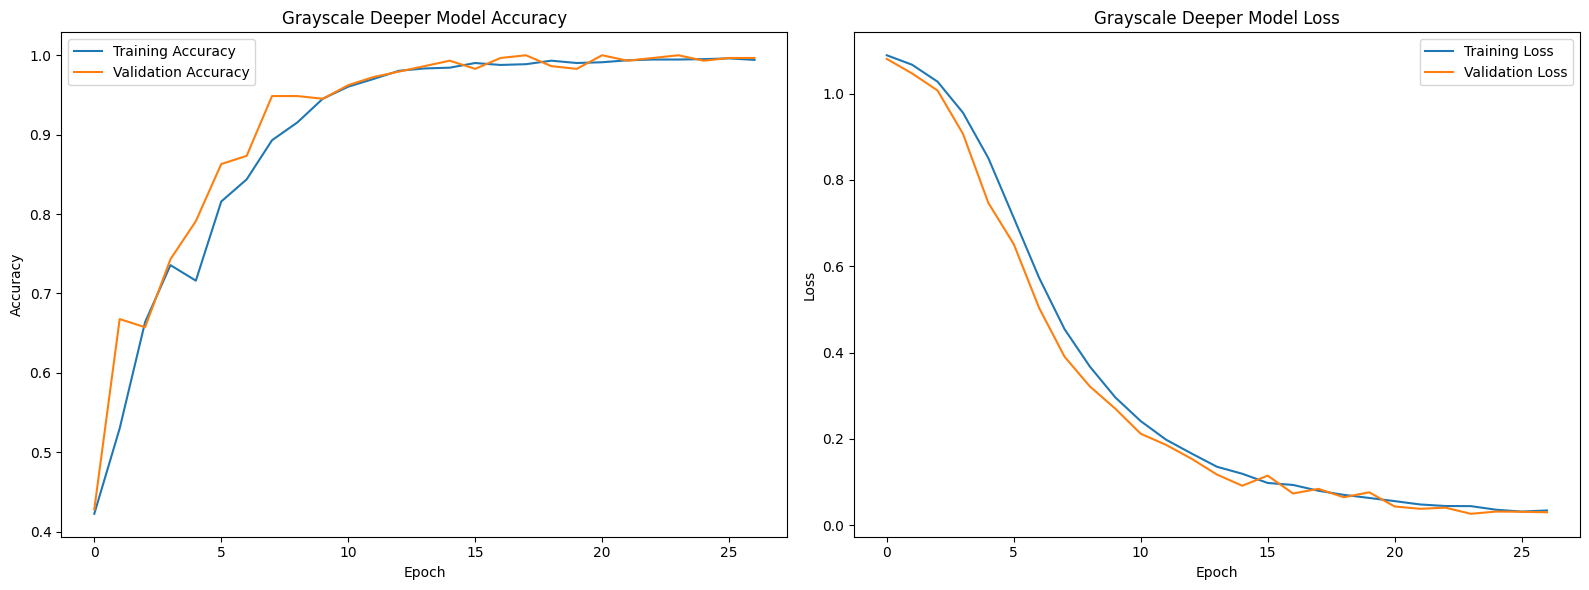

In [82]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(gray_deeper_history.history['accuracy'], label='Training Accuracy')
plt.plot(gray_deeper_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Grayscale Deeper Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gray_deeper_history.history['loss'], label='Training Loss')
plt.plot(gray_deeper_history.history['val_loss'], label='Validation Loss')
plt.title('Grayscale Deeper Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Model Comparison

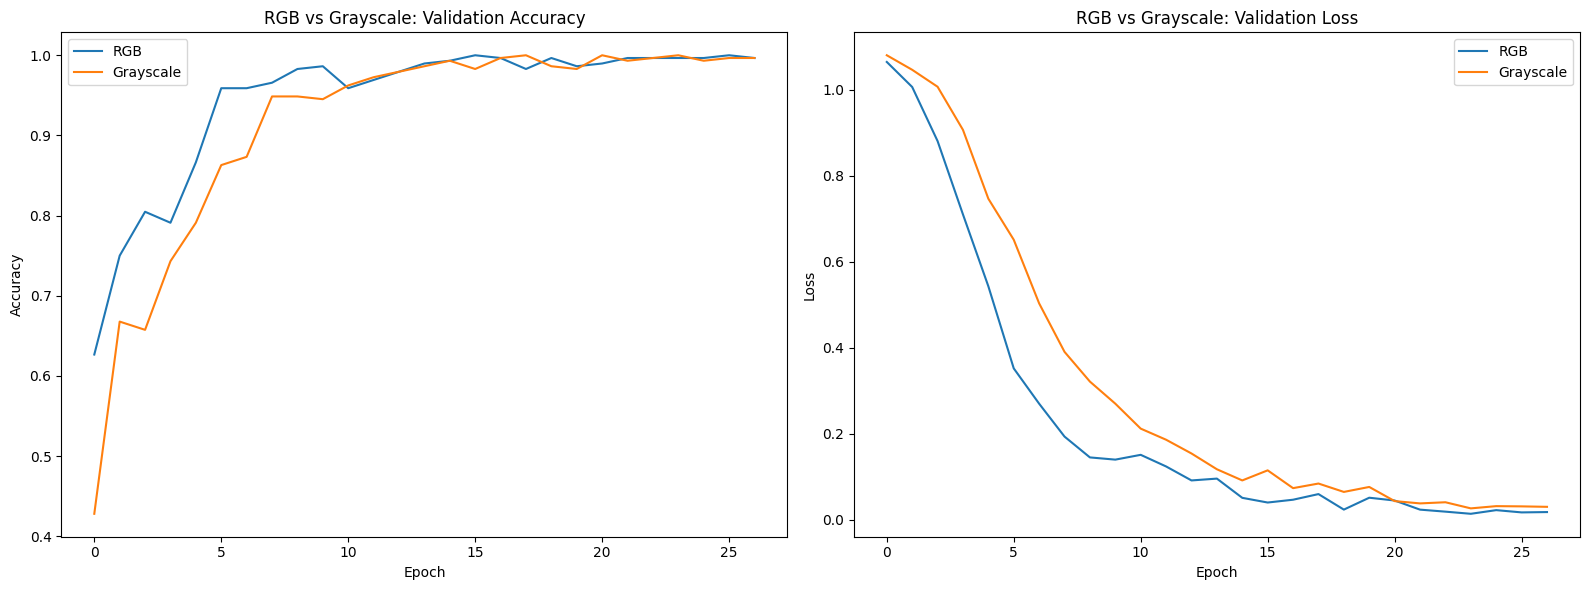

In [83]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(deeper_history.history['val_accuracy'], label='RGB')
plt.plot(gray_deeper_history.history['val_accuracy'], label='Grayscale')
plt.title('RGB vs Grayscale: Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deeper_history.history['val_loss'], label='RGB')
plt.plot(gray_deeper_history.history['val_loss'], label='Grayscale')
plt.title('RGB vs Grayscale: Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [124]:
model_names = ['RGB Deeper CNN', 'Grayscale Deeper CNN']
training_times = [deeper_training_time, gray_deeper_training_time]
val_accs = [
    deeper_history.history['val_accuracy'][np.argmin(deeper_history.history['val_loss'])],
    gray_deeper_history.history['val_accuracy'][np.argmin(gray_deeper_history.history['val_loss'])]
]
val_losses = [
    deeper_history.history['val_loss'][np.argmin(deeper_history.history['val_loss'])],
    gray_deeper_history.history['val_loss'][np.argmin(gray_deeper_history.history['val_loss'])]
]

In [85]:
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Training Time (s)': training_times,
    'Best Val. Accuracy': val_accs,
    'Best Val. Loss': val_losses
})

print("RGB vs Grayscale Comparison:")
print(comparison_df)

RGB vs Grayscale Comparison:
                  Model  Training Time (s)  Best Val. Accuracy  Best Val. Loss
0        RGB Deeper CNN           59.24643            0.996575         0.01415
1  Grayscale Deeper CNN           56.18480            1.000000         0.02675


In [86]:
color_models = {
    'RGB Deeper CNN': deeper_model,
    'Grayscale Deeper CNN': gray_deeper_model
}

test_data_mappings = {
    'RGB Deeper CNN': test_ds,
    'Grayscale Deeper CNN': grayscale_test_ds
}

prediction_models = {name: tf.keras.Sequential([model, tf.keras.layers.Softmax()])
                    for name, model in color_models.items()}

In [87]:
color_inference_results = {}

for name, model in prediction_models.items():
    print(f"Measuring inference time for {name}...")
    avg_time, std_time = measure_inference_time(model, test_data_mappings[name])
    color_inference_results[name] = {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time
    }
    print(f"{name}: {avg_time:.2f}ms ± {std_time:.2f}ms per batch")

Measuring inference time for RGB Deeper CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RGB Deeper CNN: 744.91ms ± 43.01ms per batch
Measuring inference time for Grayscale Deeper CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Grayscale Deeper CNN: 704.60ms ± 11.28ms per batch


In [88]:
color_inference_df = pd.DataFrame([{
    'Model': name,
    'Avg Inference Time (ms)': results['avg_time_ms'],
    'Std Dev (ms)': results['std_time_ms']
} for name, results in color_inference_results.items()])

print("\nInference Time Results for RGB vs Grayscale:")
print(color_inference_df)


Inference Time Results for RGB vs Grayscale:
                  Model  Avg Inference Time (ms)  Std Dev (ms)
0        RGB Deeper CNN               744.907254     43.011926
1  Grayscale Deeper CNN               704.598123     11.283713


In [89]:
model_names = ['RGB Deeper CNN', 'Grayscale Deeper CNN']
training_times = [deeper_training_time, gray_deeper_training_time]
inference_times = [color_inference_results[model]['avg_time_ms'] for model in model_names]
val_accs = [
    deeper_history.history['val_accuracy'][np.argmin(deeper_history.history['val_loss'])],
    gray_deeper_history.history['val_accuracy'][np.argmin(gray_deeper_history.history['val_loss'])]
]
val_losses = [
    deeper_history.history['val_loss'][np.argmin(deeper_history.history['val_loss'])],
    gray_deeper_history.history['val_loss'][np.argmin(gray_deeper_history.history['val_loss'])]
]

color_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Training Time (s)': training_times,
    'Inference Time (ms)': inference_times,
    'Best Val. Accuracy': val_accs,
    'Best Val. Loss': val_losses
})

print("\nComprehensive RGB vs Grayscale Comparison:")
print(color_comparison_df)


Comprehensive RGB vs Grayscale Comparison:
                  Model  Training Time (s)  Inference Time (ms)  \
0        RGB Deeper CNN           59.24643           744.907254   
1  Grayscale Deeper CNN           56.18480           704.598123   

   Best Val. Accuracy  Best Val. Loss  
0            0.996575         0.01415  
1            1.000000         0.02675  


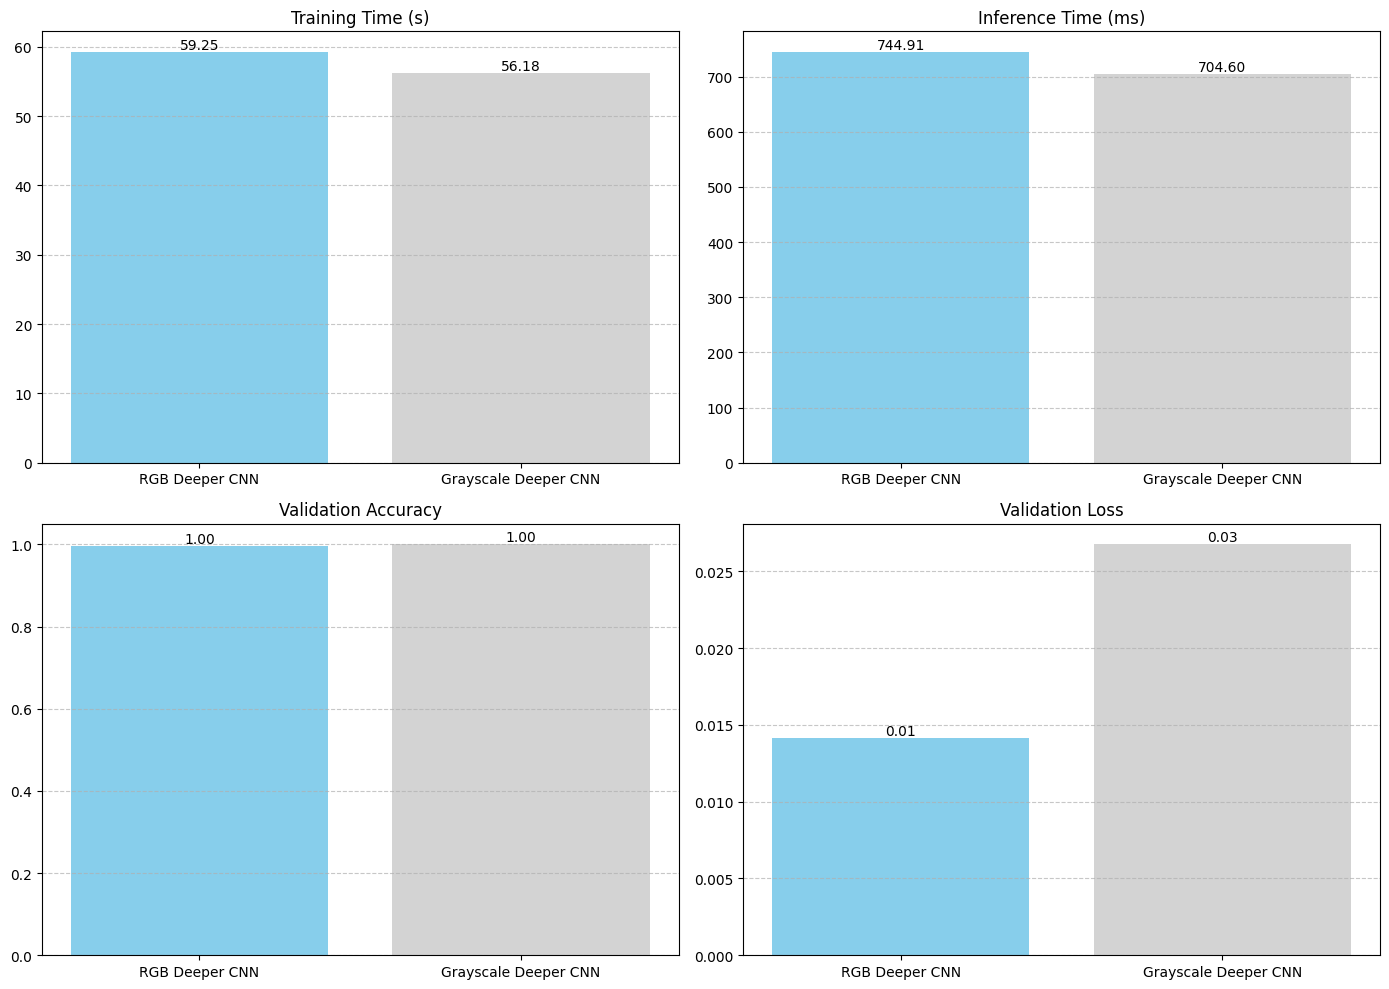

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].bar(color_comparison_df['Model'], color_comparison_df['Training Time (s)'], color=['skyblue', 'lightgray'])
ax[0, 0].set_title('Training Time (s)')
ax[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[0, 1].bar(color_comparison_df['Model'], color_comparison_df['Inference Time (ms)'], color=['skyblue', 'lightgray'])
ax[0, 1].set_title('Inference Time (ms)')
ax[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 0].bar(color_comparison_df['Model'], color_comparison_df['Best Val. Accuracy'], color=['skyblue', 'lightgray'])
ax[1, 0].set_title('Validation Accuracy')
ax[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 1].bar(color_comparison_df['Model'], color_comparison_df['Best Val. Loss'], color=['skyblue', 'lightgray'])
ax[1, 1].set_title('Validation Loss')
ax[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for i in range(2):
    for j in range(2):
        for k, bar in enumerate(ax[i, j].patches):
            height = bar.get_height()
            ax[i, j].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('rgb_grayscale_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Transfer Learning Models
## ResNet

In [92]:
inputs = tf.keras.Input(shape=(image_size, image_size, 3))

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = base_model(inputs)
base_model.trainable = False

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)

resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │         6,147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [93]:
checkpoint_filepath = '/content/drive/MyDrive/gray_deeper_cnn_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [94]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

resnet_start_time = time.time()
resnet_history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback
)
resnet_end_time = time.time()
resnet_training_time = resnet_end_time - resnet_start_time
print(f"ResNet - Training took {resnet_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3952 - loss: 1.2650
Epoch 1: val_loss improved from inf to 1.12951, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 214ms/step - accuracy: 0.3952 - loss: 1.2645 - val_accuracy: 0.4110 - val_loss: 1.1295
Epoch 2/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4416 - loss: 1.1207
Epoch 2: val_loss improved from 1.12951 to 1.08522, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4427 - loss: 1.1180 - val_accuracy: 0.4521 - val_loss: 1.0852
Epoch 3/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5472 - loss: 0.9656
Epoch 3: val_loss improved from 1.08522 to 0.85251, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5478 - loss: 0.9637 - val_accuracy: 0.6164 - val_loss: 0.8525
Epoch 4/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6162 - loss: 0.8414
Epoch 4: val_loss improved from 0.85251 to 0.75145, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6163 - loss: 0.8406 - val_accuracy: 0.6747 - val_loss: 0.7515
Epoch 5/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6593 - loss: 0.7741
Epoch 5: val_loss improved from 0.75145 to 0.69799, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6600 - loss: 0.7728 - val_accuracy: 0.7158 - val_loss: 0.6980
Epoch 6/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7183 - loss: 0.6725
Epoch 6: val_loss improved from 0.69799 to 0.64510, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7188 - loss: 0.6722 - val_accuracy: 0.7123 - val_loss: 0.6451
Epoch 7/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7573 - loss: 0.6135
Epoch 7: val_loss improved from 0.64510 to 0.49242, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7584 - loss: 0.6115 - val_accuracy: 0.8390 - val_loss: 0.4924
Epoch 8/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8071 - loss: 0.5481
Epoch 8: val_loss improved from 0.49242 to 0.47769, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8072 - loss: 0.5474 - val_accuracy: 0.8527 - val_loss: 0.4777
Epoch 9/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8187 - loss: 0.5085
Epoch 9: val_loss improved from 0.47769 to 0.46210, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8203 - loss: 0.5065 - val_accuracy: 0.8356 - val_loss: 0.4621
Epoch 10/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8603 - loss: 0.4460
Epoch 10: val_loss improved from 0.46210 to 0.43971, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8609 - loss: 0.4454 - val_accuracy: 0.8356 - val_loss: 0.4397
Epoch 11/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8792 - loss: 0.4097
Epoch 11: val_loss improved from 0.43971 to 0.38148, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8793 - loss: 0.4096 - val_accuracy: 0.9144 - val_loss: 0.3815
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9006 - loss: 0.3878
Epoch 12: val_loss did not improve from 0.38148
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9006 - loss: 0.3877 - val_accuracy: 0.9041 - val_loss: 0.3821
Epoch 13/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9050 - loss: 0.3590
Epoch 13: val_loss improved from 0.38148 to 0.31552, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9061 - loss: 0.3577 - val_accuracy: 0.9384 - val_loss: 0.3155
Epoch 14/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9205 - loss: 0.3355
Epoch 14: val_loss did not improve from 0.31552
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9210 - loss: 0.3346 - val_accuracy: 0.9281 - val_loss: 0.3286
Epoch 15/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9281 - loss: 0.3127
Epoch 15: val_loss improved from 0.31552 to 0.28181, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9288 - loss: 0.3118 - val_accuracy: 0.9623 - val_loss: 0.2818
Epoch 16/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9394 - loss: 0.2867
Epoch 16: val_loss did not improve from 0.28181
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9399 - loss: 0.2864 - val_accuracy: 0.9521 - val_loss: 0.2921
Epoch 17/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9394 - loss: 0.2753
Epoch 17: val_loss improved from 0.28181 to 0.26462, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9401 - loss: 0.2746 - val_accuracy: 0.9521 - val_loss: 0.2646
Epoch 18/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9532 - loss: 0.2515
Epoch 18: val_loss improved from 0.26462 to 0.26113, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9534 - loss: 0.2513 - val_accuracy: 0.9589 - val_loss: 0.2611
Epoch 19/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9476 - loss: 0.2486
Epoch 19: val_loss improved from 0.26113 to 0.23775, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9481 - loss: 0.2483 - val_accuracy: 0.9384 - val_loss: 0.2377
Epoch 20/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9586 - loss: 0.2211
Epoch 20: val_loss improved from 0.23775 to 0.21725, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9584 - loss: 0.2215 - val_accuracy: 0.9658 - val_loss: 0.2173
Epoch 21/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9631 - loss: 0.2170
Epoch 21: val_loss improved from 0.21725 to 0.20200, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9631 - loss: 0.2168 - val_accuracy: 0.9692 - val_loss: 0.2020
Epoch 22/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9675 - loss: 0.2105
Epoch 22: val_loss improved from 0.20200 to 0.18854, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9675 - loss: 0.2100 - val_accuracy: 0.9829 - val_loss: 0.1885
Epoch 23/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9609 - loss: 0.1999
Epoch 23: val_loss did not improve from 0.18854
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9614 - loss: 0.1993 - val_accuracy: 0.9658 - val_loss: 0.1903
Epoch 24/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9662 - loss: 0.1860
Epoch 24: val_loss did not improve from 0.18854
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9662 - loss: 0.1860 - val_accuracy: 0.9658 - val_loss: 0.2116
Epoch 25/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9640 - loss: 0.1882
Epoch 25: val_loss improved from 0.18854 to 0.18388, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9642 - loss: 0.1880 - val_accuracy: 0.9726 - val_loss: 0.1839
Epoch 26/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9670 - loss: 0.1830
Epoch 26: val_loss improved from 0.18388 to 0.17227, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9671 - loss: 0.1829 - val_accuracy: 0.9760 - val_loss: 0.1723
Epoch 27/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9773 - loss: 0.1625
Epoch 27: val_loss improved from 0.17227 to 0.16706, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9772 - loss: 0.1627 - val_accuracy: 0.9760 - val_loss: 0.1671
Epoch 28/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9777 - loss: 0.1623
Epoch 28: val_loss improved from 0.16706 to 0.14707, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9776 - loss: 0.1622 - val_accuracy: 0.9795 - val_loss: 0.1471
Epoch 29/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9789 - loss: 0.1436
Epoch 29: val_loss improved from 0.14707 to 0.13407, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9787 - loss: 0.1440 - val_accuracy: 0.9863 - val_loss: 0.1341
Epoch 30/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9778 - loss: 0.1431
Epoch 30: val_loss did not improve from 0.13407
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9779 - loss: 0.1435 - val_accuracy: 0.9795 - val_loss: 0.1463
Epoch 31/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9773 - loss: 0.1444
Epoch 31: val_loss did not improve from 0.13407
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9774 - loss: 0.1442 - val_accuracy: 0.9726 - val_loss: 0.1469
Epoch 32/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.1376
Epoch 32: val_loss improved from 0.13407 to 0.12482, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9787 - loss: 0.1376 - val_accuracy: 0.9829 - val_loss: 0.1248
Epoch 33/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9785 - loss: 0.1331
Epoch 33: val_loss did not improve from 0.12482
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9786 - loss: 0.1331 - val_accuracy: 0.9829 - val_loss: 0.1272
Epoch 34/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9812 - loss: 0.1250
Epoch 34: val_loss improved from 0.12482 to 0.11409, saving model to /content/drive/MyDrive/gray_deeper_cnn_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9812 - loss: 0.1251 - val_accuracy: 0.9897 - val_loss: 0.1141
Epoch 35/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.1230
Epoch 35: val_loss did not improve from 0.11409
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9826 - loss: 0.1230 - val_accuracy: 0.9726 - val_loss: 0.1342
Epoch 36/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9847 - loss: 0.1189
Epoch 36: val_loss did not improve from 0.11409
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9848 - loss: 0.1189 - val_accuracy: 0.9795 - val_loss: 0.1340
Epoch 37/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9865 - loss: 0.1141
Epoch 37: val_loss did not improve from 0.11409
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9865 - loss: 0.1141 - val_accuracy: 0.9795 - val_loss: 0.1214
ResNet - Training took 89.44 seconds


In [95]:
best_epoch_index = np.argmin(resnet_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = resnet_history.history['val_loss'][best_epoch_index]
best_val_accuracy = resnet_history.history['val_accuracy'][best_epoch_index]
best_training_loss = resnet_history.history['loss'][best_epoch_index]
best_training_accuracy = resnet_history.history['accuracy'][best_epoch_index]

print("ResNet Transfer Learning Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {resnet_training_time:.2f} seconds")

ResNet Transfer Learning Model Information:
Best Epoch: 34
Validation Loss: 0.114086
Validation Accuracy: 0.989726
Training Loss: 0.128358
Training Accuracy: 0.980459
Training Time: 89.44 seconds


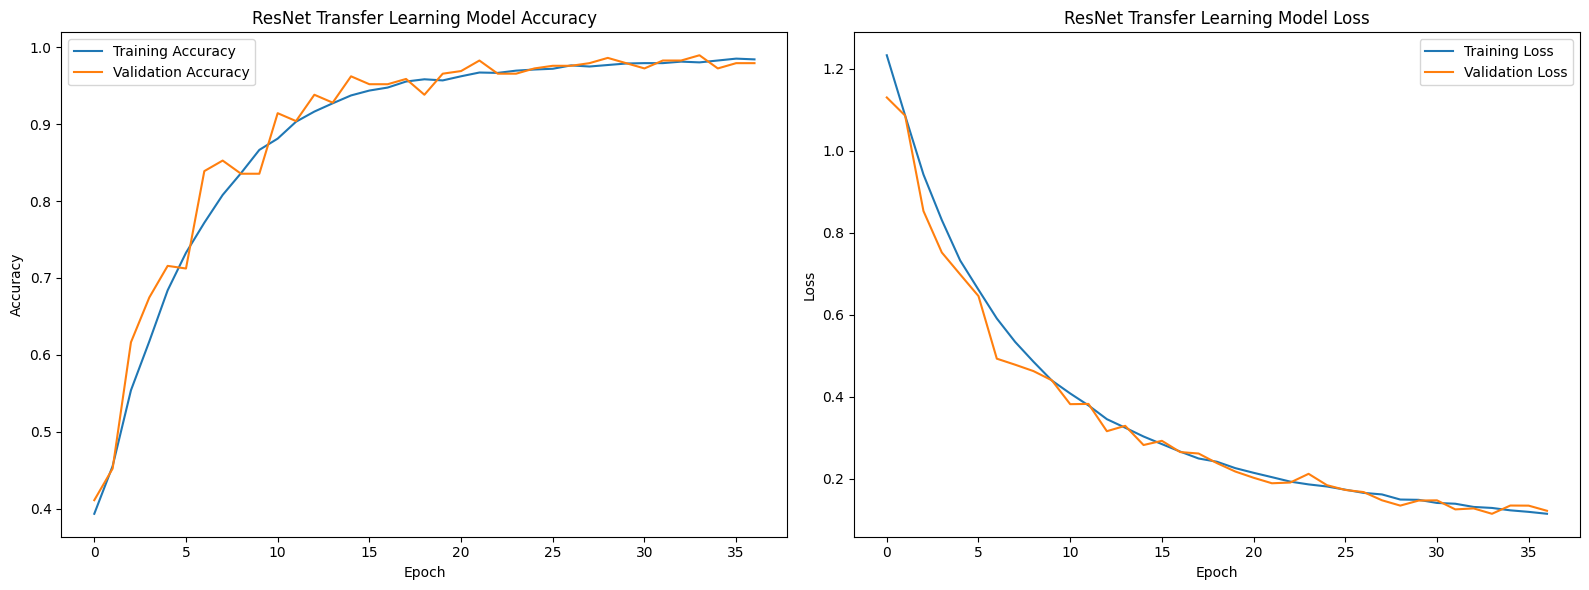

In [96]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## VGG-16

In [97]:
vgg_inputs = tf.keras.Input(shape=(image_size, image_size, 3))

preprocessing_layer = tf.keras.layers.Lambda(lambda x: preprocess_input(x))
preprocessed_inputs = preprocessing_layer(vgg_inputs)

vgg_base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
vgg_x = vgg_base_model(preprocessed_inputs)
vgg_base_model.trainable = False

vgg_x = layers.GlobalAveragePooling2D()(vgg_x)
vgg_x = layers.Dense(512, activation='relu')(vgg_x)
vgg_outputs = layers.Dense(num_classes)(vgg_x)

vgg_model = tf.keras.Model(vgg_inputs, vgg_outputs)

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [98]:
checkpoint_filepath = '/content/drive/MyDrive/vgg16_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [99]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

vgg_start_time = time.time()
vgg_history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callback
)
vgg_end_time = time.time()
vgg_training_time = vgg_end_time - vgg_start_time
print(f"VGG-16 - Training took {vgg_training_time:.2f} seconds")

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3573 - loss: 4.8980
Epoch 1: val_loss improved from inf to 3.96222, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 269ms/step - accuracy: 0.3575 - loss: 4.8911 - val_accuracy: 0.4075 - val_loss: 3.9622
Epoch 2/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4369 - loss: 3.5974
Epoch 2: val_loss improved from 3.96222 to 2.79724, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4371 - loss: 3.5786 - val_accuracy: 0.4829 - val_loss: 2.7972
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5014 - loss: 2.6952
Epoch 3: val_loss improved from 2.79724 to 1.87565, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5014 - loss: 2.6931 - val_accuracy: 0.5445 - val_loss: 1.8756
Epoch 4/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5654 - loss: 2.0652
Epoch 4: val_loss improved from 1.87565 to 1.47695, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5659 - loss: 2.0559 - val_accuracy: 0.5993 - val_loss: 1.4770
Epoch 5/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6304 - loss: 1.6480
Epoch 5: val_loss improved from 1.47695 to 1.32118, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6309 - loss: 1.6388 - val_accuracy: 0.6644 - val_loss: 1.3212
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6786 - loss: 1.2011
Epoch 6: val_loss improved from 1.32118 to 1.29848, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6800 - loss: 1.1967 - val_accuracy: 0.6747 - val_loss: 1.2985
Epoch 7/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7275 - loss: 0.9990
Epoch 7: val_loss improved from 1.29848 to 0.86723, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7284 - loss: 0.9948 - val_accuracy: 0.7500 - val_loss: 0.8672
Epoch 8/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7618 - loss: 0.7915
Epoch 8: val_loss improved from 0.86723 to 0.60532, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7626 - loss: 0.7871 - val_accuracy: 0.7979 - val_loss: 0.6053
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8031 - loss: 0.5998
Epoch 9: val_loss did not improve from 0.60532
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8037 - loss: 0.5988 - val_accuracy: 0.7945 - val_loss: 0.6220
Epoch 10/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8298 - loss: 0.5252
Epoch 10: val_loss improved from 0.60532 to 0.44243, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8301 - loss: 0.5233 - val_accuracy: 0.8562 - val_loss: 0.4424
Epoch 11/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8507 - loss: 0.4168
Epoch 11: val_loss improved from 0.44243 to 0.30537, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8514 - loss: 0.4155 - val_accuracy: 0.9110 - val_loss: 0.3054
Epoch 12/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8775 - loss: 0.3248
Epoch 12: val_loss improved from 0.30537 to 0.24943, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8780 - loss: 0.3244 - val_accuracy: 0.9110 - val_loss: 0.2494
Epoch 13/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9014 - loss: 0.2574
Epoch 13: val_loss did not improve from 0.24943
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9016 - loss: 0.2574 - val_accuracy: 0.8904 - val_loss: 0.2914
Epoch 14/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9085 - loss: 0.2441
Epoch 14: val_loss improved from 0.24943 to 0.18283, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9088 - loss: 0.2435 - val_accuracy: 0.9315 - val_loss: 0.1828
Epoch 15/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9185 - loss: 0.2351
Epoch 15: val_loss improved from 0.18283 to 0.17355, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9190 - loss: 0.2336 - val_accuracy: 0.9384 - val_loss: 0.1736
Epoch 16/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9424 - loss: 0.1722
Epoch 16: val_loss did not improve from 0.17355
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9424 - loss: 0.1725 - val_accuracy: 0.9315 - val_loss: 0.2084
Epoch 17/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9535 - loss: 0.1433
Epoch 17: val_loss improved from 0.17355 to 0.16714, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9532 - loss: 0.1444 - val_accuracy: 0.9623 - val_loss: 0.1671
Epoch 18/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9556 - loss: 0.1352
Epoch 18: val_loss did not improve from 0.16714
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9557 - loss: 0.1351 - val_accuracy: 0.9486 - val_loss: 0.1775
Epoch 19/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9658 - loss: 0.1079
Epoch 19: val_loss improved from 0.16714 to 0.10469, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9655 - loss: 0.1087 - val_accuracy: 0.9623 - val_loss: 0.1047
Epoch 20/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9652 - loss: 0.1096
Epoch 20: val_loss improved from 0.10469 to 0.08315, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9650 - loss: 0.1097 - val_accuracy: 0.9692 - val_loss: 0.0832
Epoch 21/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9691 - loss: 0.1019
Epoch 21: val_loss did not improve from 0.08315
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9690 - loss: 0.1019 - val_accuracy: 0.9589 - val_loss: 0.1484
Epoch 22/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9672 - loss: 0.0948
Epoch 22: val_loss improved from 0.08315 to 0.07045, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9675 - loss: 0.0940 - val_accuracy: 0.9726 - val_loss: 0.0705
Epoch 23/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9696 - loss: 0.0803
Epoch 23: val_loss did not improve from 0.07045
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9698 - loss: 0.0799 - val_accuracy: 0.9623 - val_loss: 0.1122
Epoch 24/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9764 - loss: 0.0819
Epoch 24: val_loss improved from 0.07045 to 0.05212, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9762 - loss: 0.0818 - val_accuracy: 0.9760 - val_loss: 0.0521
Epoch 25/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9808 - loss: 0.0628
Epoch 25: val_loss did not improve from 0.05212
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9807 - loss: 0.0631 - val_accuracy: 0.9692 - val_loss: 0.0782
Epoch 26/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.0611
Epoch 26: val_loss did not improve from 0.05212
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9817 - loss: 0.0611 - val_accuracy: 0.9897 - val_loss: 0.0548
Epoch 27/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0596
Epoch 27: val_loss did not improve from 0.05212
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9815 - loss: 0.0598 - val_accuracy: 0.9795 - val_loss: 0.0620
Epoch 28/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9860 - loss: 0.0463
Epoch 28: val_loss improved from 0.05212 to 0.03

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9858 - loss: 0.0466 - val_accuracy: 0.9897 - val_loss: 0.0320
Epoch 29/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.0512
Epoch 29: val_loss did not improve from 0.03196
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9841 - loss: 0.0514 - val_accuracy: 0.9897 - val_loss: 0.0465
Epoch 30/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9884 - loss: 0.0483
Epoch 30: val_loss did not improve from 0.03196
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9883 - loss: 0.0483 - val_accuracy: 0.9692 - val_loss: 0.0624
Epoch 31/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9867 - loss: 0.0543
Epoch 31: val_loss did not improve from 0.03196
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9867 - loss: 0.0536 - val_accuracy: 0.9897 - val_loss: 0.0422
Epoch 32/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9887 - loss: 0.0396
Epoch 32: val_loss did not improve from 0.031

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9862 - loss: 0.0556 - val_accuracy: 0.9897 - val_loss: 0.0301
Epoch 34/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9907 - loss: 0.0389
Epoch 34: val_loss did not improve from 0.03015
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9908 - loss: 0.0387 - val_accuracy: 0.9897 - val_loss: 0.0592
Epoch 35/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9896 - loss: 0.0413
Epoch 35: val_loss improved from 0.03015 to 0.02722, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9896 - loss: 0.0411 - val_accuracy: 0.9932 - val_loss: 0.0272
Epoch 36/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9897 - loss: 0.0334
Epoch 36: val_loss did not improve from 0.02722
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9900 - loss: 0.0332 - val_accuracy: 0.9966 - val_loss: 0.0314
Epoch 37/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9941 - loss: 0.0290
Epoch 37: val_loss improved from 0.02722 to 0.02441, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9941 - loss: 0.0292 - val_accuracy: 0.9932 - val_loss: 0.0244
Epoch 38/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9929 - loss: 0.0299
Epoch 38: val_loss improved from 0.02441 to 0.02402, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9929 - loss: 0.0299 - val_accuracy: 0.9966 - val_loss: 0.0240
Epoch 39/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9951 - loss: 0.0330
Epoch 39: val_loss improved from 0.02402 to 0.01704, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9950 - loss: 0.0325 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 40/100
63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9969 - loss: 0.0272
Epoch 40: val_loss improved from 0.01704 to 0.01542, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9968 - loss: 0.0272 - val_accuracy: 0.9966 - val_loss: 0.0154
Epoch 41/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9978 - loss: 0.0169
Epoch 41: val_loss improved from 0.01542 to 0.01156, saving model to /content/drive/MyDrive/vgg16_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9977 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0116
Epoch 42/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0180
Epoch 42: val_loss did not improve from 0.01156
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9968 - loss: 0.0182 - val_accuracy: 1.0000 - val_loss: 0.0137
Epoch 43/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0204
Epoch 43: val_loss did not improve from 0.01156
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9977 - loss: 0.0204 - val_accuracy: 0.9932 - val_loss: 0.0234
Epoch 44/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9987 - loss: 0.0157
Epoch 44: val_loss did not improve from 0.01156
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9986 - loss: 0.0158 - val_accuracy: 0.9966 - val_loss: 0.0172
Epoch 45/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9972 - loss: 0.0190
Epoch 45: val_loss did not improve from 0.01156


In [100]:
best_epoch_index = np.argmin(vgg_history.history['val_loss'])
best_epoch = best_epoch_index + 1

best_val_loss = vgg_history.history['val_loss'][best_epoch_index]
best_val_accuracy = vgg_history.history['val_accuracy'][best_epoch_index]
best_training_loss = vgg_history.history['loss'][best_epoch_index]
best_training_accuracy = vgg_history.history['accuracy'][best_epoch_index]

print("VGG-16 Transfer Learning Model Information:")
print(f"Best Epoch: {best_epoch}")
print(f"Validation Loss: {best_val_loss:.6f}")
print(f"Validation Accuracy: {best_val_accuracy:.6f}")
print(f"Training Loss: {best_training_loss:.6f}")
print(f"Training Accuracy: {best_training_accuracy:.6f}")
print(f"Training Time: {vgg_training_time:.2f} seconds")

VGG-16 Transfer Learning Model Information:
Best Epoch: 41
Validation Loss: 0.011559
Validation Accuracy: 1.000000
Training Loss: 0.021871
Training Accuracy: 0.995603
Training Time: 87.93 seconds


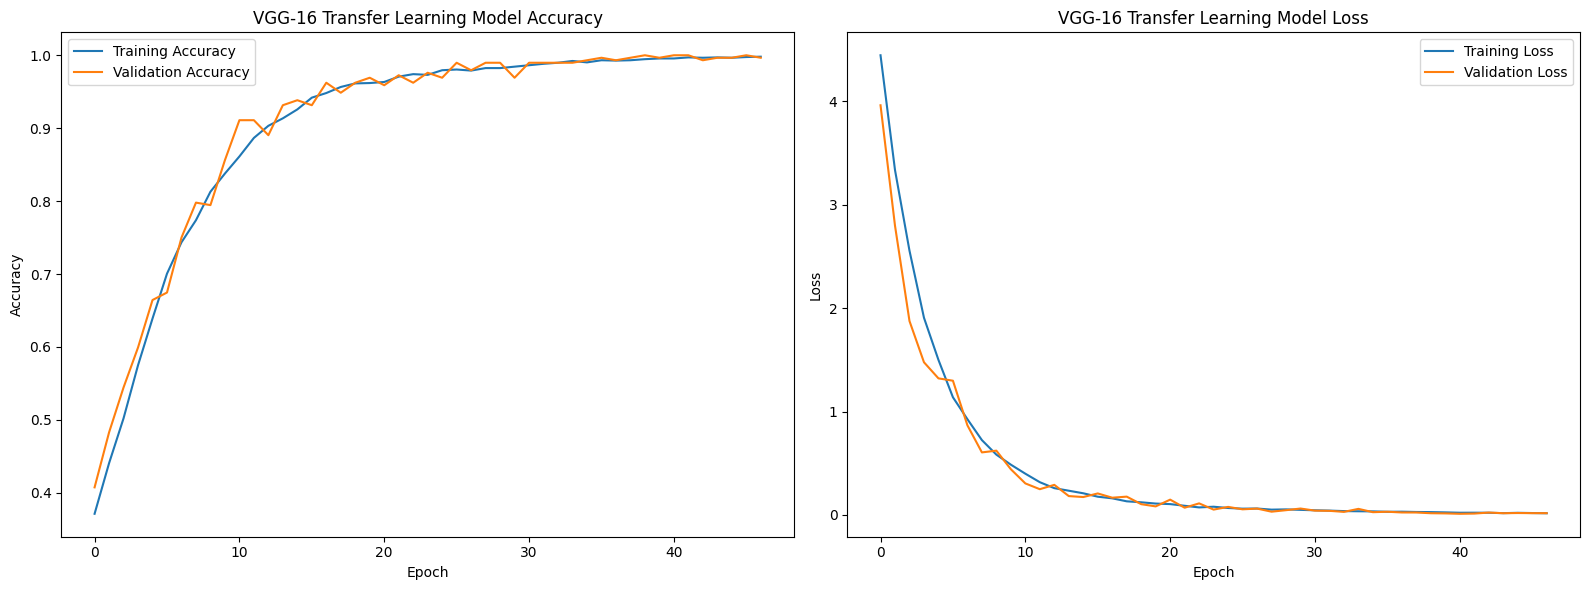

In [101]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG-16 Transfer Learning Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Training Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('VGG-16 Transfer Learning Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [102]:
for layer in vgg_base_model.layers[-4:]:
    layer.trainable = True

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [103]:
checkpoint_filepath = '/content/drive/MyDrive/vgg16_model_tuned.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [104]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    model_checkpoint_callback
]

fine_tune_start_time = time.time()
fine_tune_history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=callback
)
fine_tune_end_time = time.time()
fine_tune_time = fine_tune_end_time - fine_tune_start_time

print(f"Fine-tuning took {fine_tune_time:.2f} seconds")

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9979 - loss: 0.0194
Epoch 1: val_loss improved from inf to 0.00342, saving model to /content/drive/MyDrive/vgg16_model_tuned.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.9979 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0034
Fine-tuning took 26.17 seconds


In [105]:
fine_tune_val_loss = fine_tune_history.history['val_loss'][0]
fine_tune_val_accuracy = fine_tune_history.history['val_accuracy'][0]
fine_tune_training_loss = fine_tune_history.history['loss'][0]
fine_tune_training_accuracy = fine_tune_history.history['accuracy'][0]

print("\nAfter Fine-Tuning:")
print(f"Validation Loss: {fine_tune_val_loss:.6f}")
print(f"Validation Accuracy: {fine_tune_val_accuracy:.6f}")
print(f"Training Loss: {fine_tune_training_loss:.6f}")
print(f"Training Accuracy: {fine_tune_training_accuracy:.6f}")

print("\nImprovement from Fine-Tuning:")
print(f"Validation Loss: {best_val_loss:.6f} → {fine_tune_val_loss:.6f} ({best_val_loss - fine_tune_val_loss:.6f})")
print(f"Validation Accuracy: {best_val_accuracy:.6f} → {fine_tune_val_accuracy:.6f} ({fine_tune_val_accuracy - best_val_accuracy:.6f})")


After Fine-Tuning:
Validation Loss: 0.003423
Validation Accuracy: 1.000000
Training Loss: 0.013371
Training Accuracy: 0.998534

Improvement from Fine-Tuning:
Validation Loss: 0.011559 → 0.003423 (0.008135)
Validation Accuracy: 1.000000 → 1.000000 (0.000000)


## Model Comparison

In [106]:
vgg_val_accuracy = fine_tune_val_accuracy
vgg_val_loss = fine_tune_val_loss
vgg_total_time = vgg_training_time + fine_tune_time

model_names_transfer = ['ResNet50', 'VGG16']
training_times_transfer = [resnet_training_time, vgg_total_time]
val_accuracies_transfer = [
    resnet_history.history['val_accuracy'][np.argmin(resnet_history.history['val_loss'])],
    vgg_val_accuracy
]
val_losses_transfer = [
    resnet_history.history['val_loss'][np.argmin(resnet_history.history['val_loss'])],
    vgg_val_loss
]

transfer_model_comparison_df = pd.DataFrame({
    'Model': model_names_transfer,
    'Training Time (s)': training_times_transfer,
    'Best Val. Accuracy': val_accuracies_transfer,
    'Best Val. Loss': val_losses_transfer
})

print("Transfer Learning Models Comparison:")
print(transfer_model_comparison_df)

Transfer Learning Models Comparison:
      Model  Training Time (s)  Best Val. Accuracy  Best Val. Loss
0  ResNet50          89.439550            0.989726        0.114086
1     VGG16         114.099928            1.000000        0.003423


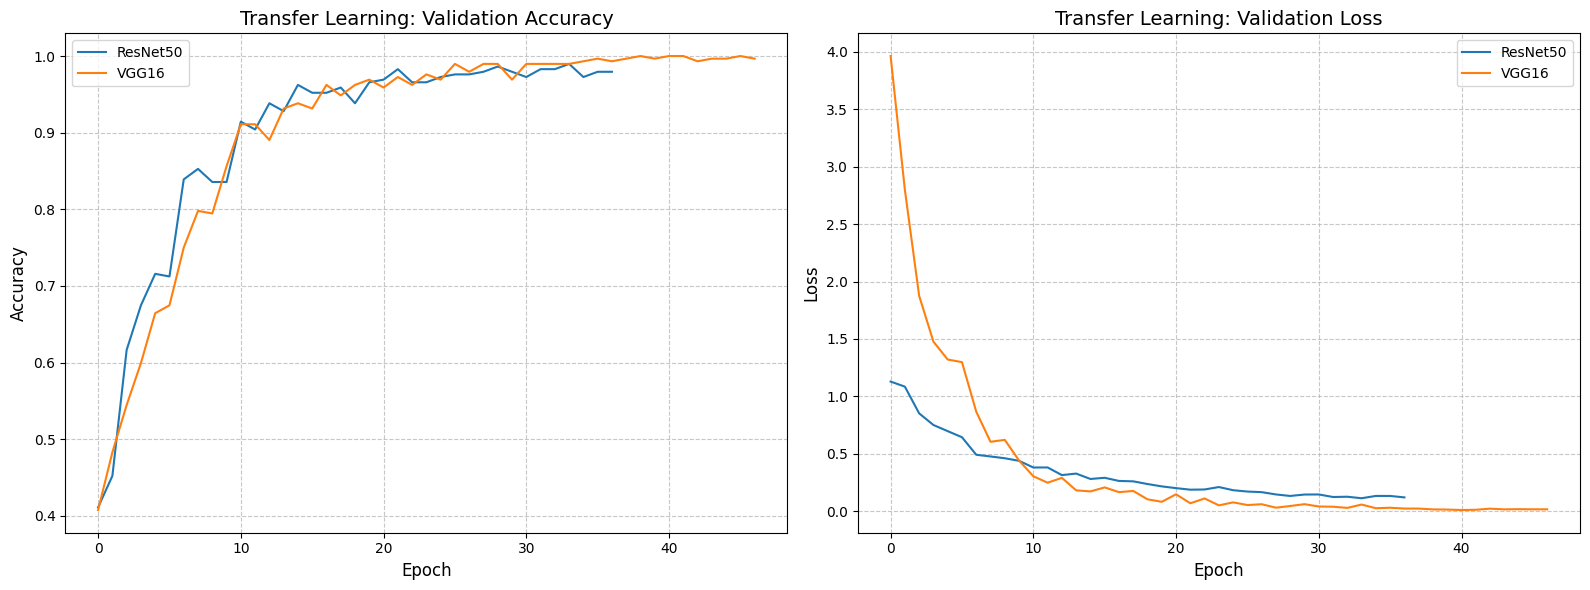

In [109]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50')
plt.plot(vgg_history.history['val_accuracy'], label='VGG16')
plt.title('Transfer Learning: Validation Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['val_loss'], label='ResNet50')
plt.plot(vgg_history.history['val_loss'], label='VGG16')
plt.title('Transfer Learning: Validation Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.savefig('transfer_learning_validation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [112]:
transfer_models = {
    'Deeper CNN': deeper_model,
    'ResNet50': resnet_model,
    'VGG16': vgg_model
}

prediction_models = {name: tf.keras.Sequential([model, tf.keras.layers.Softmax()])
                    for name, model in transfer_models.items()}

In [113]:
transfer_inference_results = {}

for name, model in prediction_models.items():
    print(f"Measuring inference time for {name}...")
    avg_time, std_time = measure_inference_time(model, test_ds)
    transfer_inference_results[name] = {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time
    }
    print(f"{name}: {avg_time:.2f}ms ± {std_time:.2f}ms per batch")

Measuring inference time for Deeper CNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Deeper CNN: 744.52ms ± 96.02ms per batch
Measuring inference time for ResNet50...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ResNet50: 699.11ms ± 28.60ms per batch
Measuring inference time for VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
VGG16: 672.05ms ± 1.71ms per batch


In [114]:
transfer_inference_df = pd.DataFrame([{
    'Model': name,
    'Avg Inference Time (ms)': results['avg_time_ms'],
    'Std Dev (ms)': results['std_time_ms']
} for name, results in transfer_inference_results.items()])

print("\nInference Time Results for Custom vs Transfer Learning Models:")
print(transfer_inference_df)


Inference Time Results for Custom vs Transfer Learning Models:
        Model  Avg Inference Time (ms)  Std Dev (ms)
0  Deeper CNN               744.515179     96.021914
1    ResNet50               699.110973     28.599657
2       VGG16               672.045369      1.708086


In [123]:
model_names = ['Deeper CNN', 'ResNet50', 'VGG16']
training_times = [deeper_training_time, resnet_training_time, vgg_total_time]
inference_times = [transfer_inference_results[model]['avg_time_ms'] for model in model_names]
val_accs = [
    deeper_history.history['val_accuracy'][np.argmin(deeper_history.history['val_loss'])],
    resnet_history.history['val_accuracy'][np.argmin(resnet_history.history['val_loss'])],
    vgg_val_accuracy
]
val_losses = [
    deeper_history.history['val_loss'][np.argmin(deeper_history.history['val_loss'])],
    resnet_history.history['val_loss'][np.argmin(resnet_history.history['val_loss'])],
    vgg_val_loss
]

transfer_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Training Time (s)': training_times,
    'Inference Time (ms)': inference_times,
    'Best Val. Accuracy': val_accs,
    'Best Val. Loss': val_losses
})

print(transfer_comparison_df)

        Model  Training Time (s)  Inference Time (ms)  Best Val. Accuracy  \
0  Deeper CNN          59.246430           744.515179            0.996575   
1    ResNet50          89.439550           699.110973            0.989726   
2       VGG16         114.099928           672.045369            1.000000   

   Best Val. Loss  
0        0.014150  
1        0.114086  
2        0.003423  


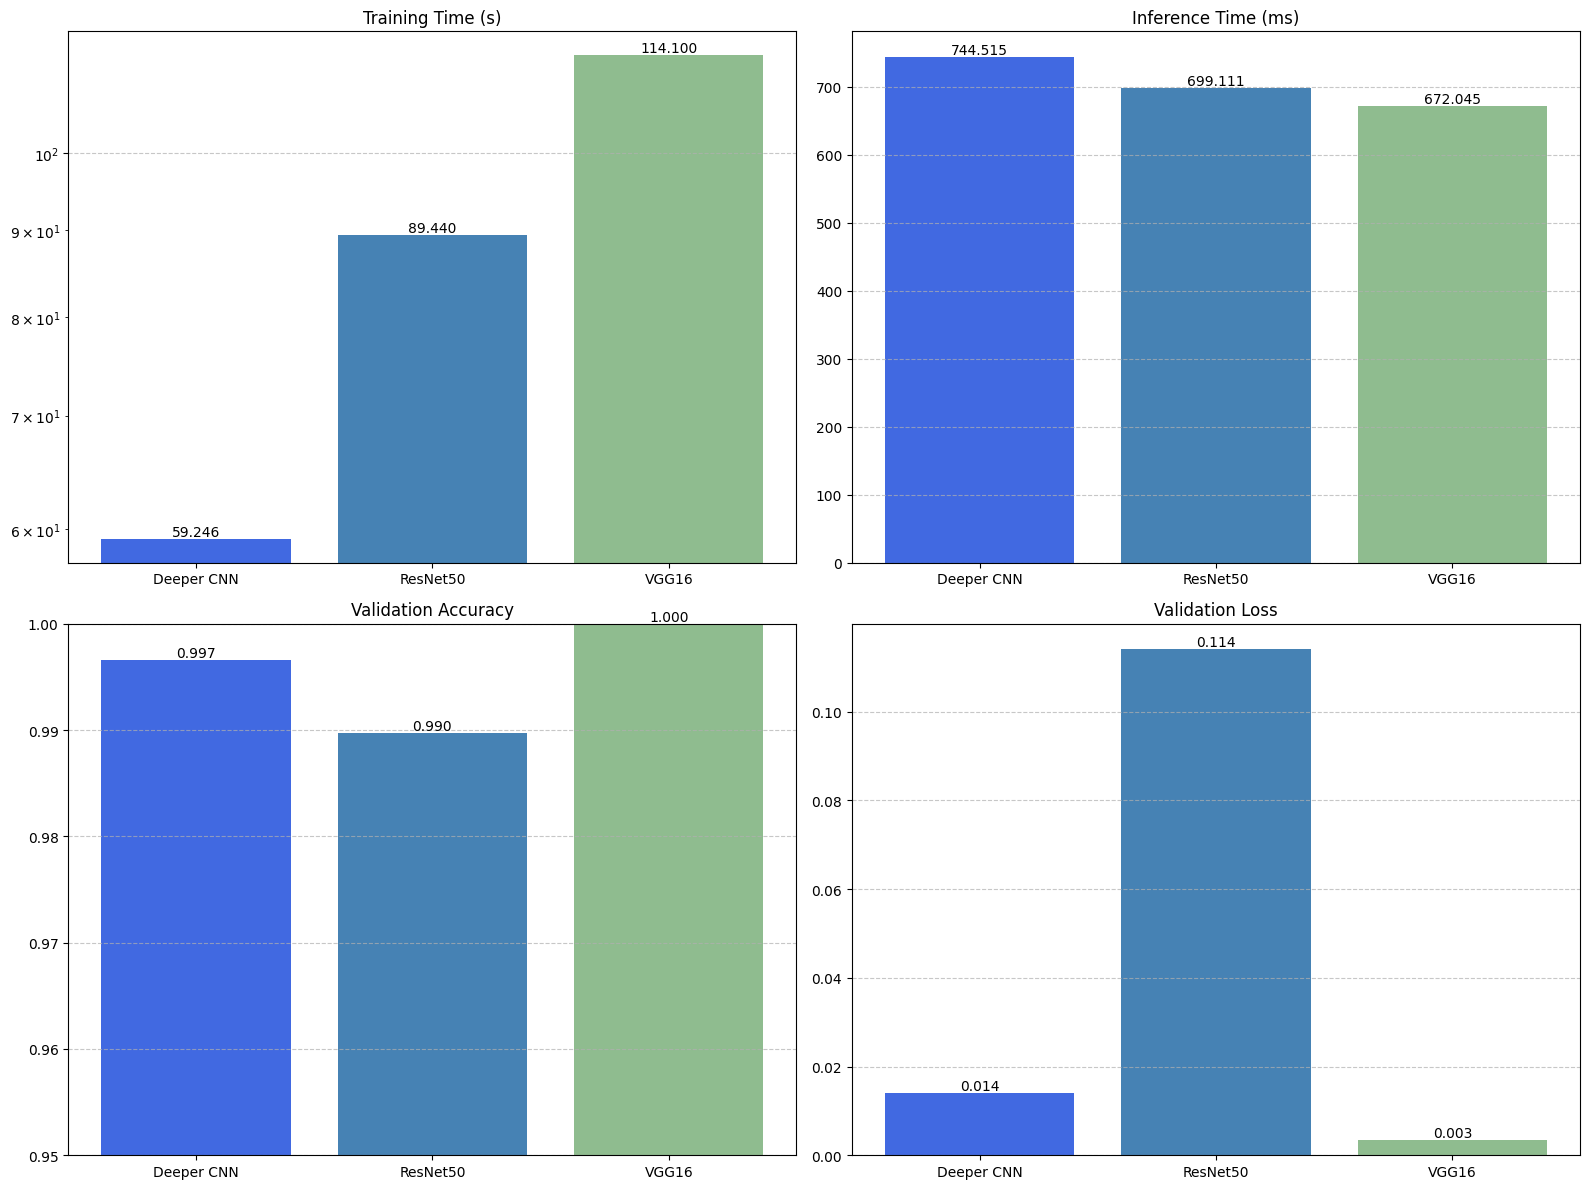

In [117]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].bar(transfer_comparison_df['Model'], transfer_comparison_df['Training Time (s)'],
            color=['royalblue', 'steelblue', 'darkseagreen'])
ax[0, 0].set_title('Training Time (s)')
ax[0, 0].set_yscale('log')
ax[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[0, 1].bar(transfer_comparison_df['Model'], transfer_comparison_df['Inference Time (ms)'],
            color=['royalblue', 'steelblue', 'darkseagreen'])
ax[0, 1].set_title('Inference Time (ms)')
ax[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 0].bar(transfer_comparison_df['Model'], transfer_comparison_df['Best Val. Accuracy'],
            color=['royalblue', 'steelblue', 'darkseagreen'])
ax[1, 0].set_title('Validation Accuracy')
ax[1, 0].set_ylim(0.95, 1.0)
ax[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

ax[1, 1].bar(transfer_comparison_df['Model'], transfer_comparison_df['Best Val. Loss'],
            color=['royalblue', 'steelblue', 'darkseagreen'])
ax[1, 1].set_title('Validation Loss')
ax[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for i in range(2):
    for j in range(2):
        for k, bar in enumerate(ax[i, j].patches):
            height = bar.get_height()
            ax[i, j].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('custom_transfer_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Inference and Test Set Evaluation

In [118]:
test_loss, test_accuracy = deeper_model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9709 - loss: 0.0857
Test accuracy: 0.9539
Test loss: 0.1428


In [119]:
image_folder = '/content/drive/My Drive/model_classifying'

def classify_all_images(probability_model, pixel_size):
    IMG_SIZE = [pixel_size, pixel_size]
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpeg')]

    results = []
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)

        print(f"\nClassifying: {image_file}")
        img = Image.open(image_path).resize((IMG_SIZE[0], IMG_SIZE[1]))
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img_array = np.array(img)
        img_array = img_array.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 3)

        ans = probability_model.predict(img_array)
        prediction = pd.DataFrame(ans, columns=class_names).idxmax(axis=1)[0]
        confidence = np.max(ans[0]) * 100

        print(f"Prediction: {prediction}")
        print(f"Confidence: {confidence:.2f}%")

        for i, class_name in enumerate(class_names):
            print(f"{class_name}: {ans[0][i]*100:.2f}%")

        results.append({
            'file': image_file,
            'prediction': prediction,
            'confidence': confidence
        })

    print("\nSummary of all predictions:")
    for result in results:
        print(f"{result['file']}: {result['prediction']} ({result['confidence']:.2f}%)")

In [120]:
model_path = '/content/drive/MyDrive/deeper_cnn_model.h5'
deeper_cnn_model = tf.keras.models.load_model(model_path)

probability_model = tf.keras.Sequential([
    deeper_cnn_model,
    tf.keras.layers.Softmax()
])


Classifying: scissors.jpeg


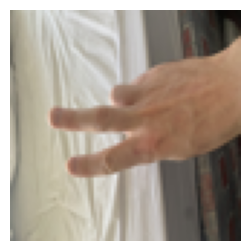

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Prediction: scissors
Confidence: 59.89%
paper: 38.93%
rock: 1.18%
scissors: 59.89%

Classifying: paper.jpeg


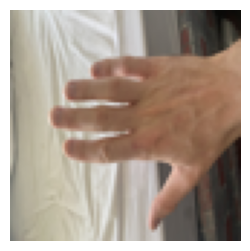

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: paper
Confidence: 79.95%
paper: 79.95%
rock: 9.63%
scissors: 10.42%

Classifying: scissors2.jpeg


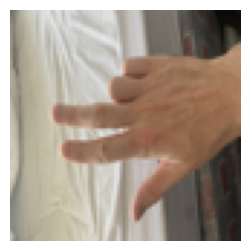

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: scissors
Confidence: 50.89%
paper: 47.34%
rock: 1.78%
scissors: 50.89%

Classifying: rock.jpeg


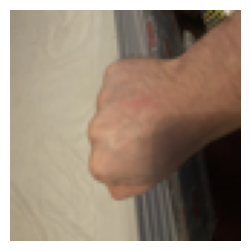

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: scissors
Confidence: 67.20%
paper: 31.09%
rock: 1.71%
scissors: 67.20%

Summary of all predictions:
scissors.jpeg: scissors (59.89%)
paper.jpeg: paper (79.95%)
scissors2.jpeg: scissors (50.89%)
rock.jpeg: scissors (67.20%)


In [121]:
classify_all_images(probability_model, image_size)

In [126]:
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = probability_model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    y_pred.extend(pred_labels.numpy())
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


In [127]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       paper       0.98      0.88      0.93       191
        rock       0.93      0.98      0.95       196
    scissors       0.97      1.00      0.98       199

    accuracy                           0.96       586
   macro avg       0.96      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586



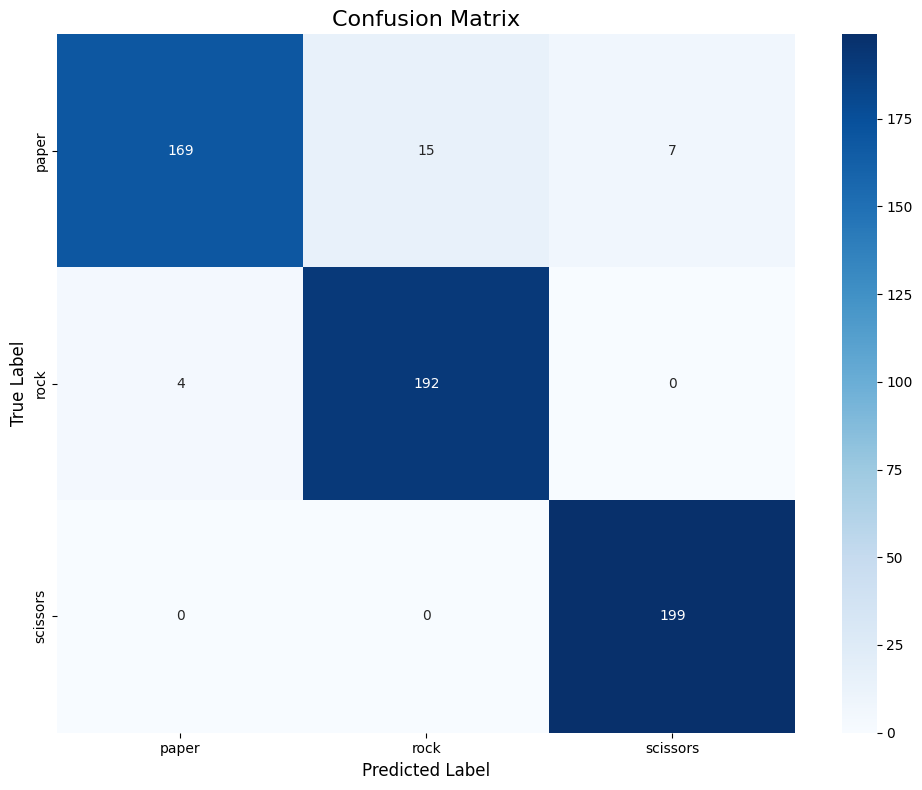

In [128]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()